In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Statistical tests
from scipy.stats import chi2_contingency, ttest_ind
from scipy import stats

In [3]:
# Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix,
                           roc_auc_score, roc_curve, precision_recall_curve,
                           accuracy_score, precision_score, recall_score, f1_score,
                           mean_squared_error, r2_score, mean_absolute_error)
from sklearn.utils.class_weight import compute_class_weight

In [4]:
# Class Imbalance Handling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

In [5]:
# Set visualization style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
fig_size = (12, 8)

# 1. DATA LOADING AND EXPLORATION

In [6]:
# Load the dataset
try:
    df = pd.read_csv('streamworks_user_data.csv')

    print(f"✅ Dataset loaded successfully!")
    print(f"Shape: {df.shape[0]} rows, {df.shape[1]} columns")
except Exception as e:
    print(f"❌ Error loading dataset: {e}")
    print("Please ensure 'streamworks_user_data.csv' is available")

✅ Dataset loaded successfully!
Shape: 1500 rows, 14 columns


In [7]:
# Remove completely empty rows
df = df.dropna(how='all')
print(f"After removing empty rows: {df.shape[0]} rows, {df.shape[1]} columns")

After removing empty rows: 1500 rows, 14 columns


In [8]:
# Display first few rows
print(f"📋 FIRST 5 ROWS:")
print(df.head())

📋 FIRST 5 ROWS:
   user_id   age  gender signup_date last_active_date  country  \
0   1001.0  56.0   Other    02-04-25         13-07-25   France   
1   1002.0  69.0    Male    02-01-23         13-07-25    India   
2   1003.0  46.0    Male    21-08-22         13-07-25       UK   
3   1004.0  32.0   Other    14-09-23         13-07-25  Germany   
4   1005.0  60.0  Female    29-07-23         13-07-25    India   

  subscription_type  average_watch_hours  mobile_app_usage_pct  \
0          Standard                 42.6                  77.4   
1             Basic                 65.3                  98.0   
2           Premium                 40.1                  47.8   
3           Premium                  5.8                  53.2   
4          Standard                 32.7                  16.8   

   complaints_raised received_promotions referred_by_friend  is_churned  \
0                1.0                  No                 No         1.0   
1                4.0                  No

In [9]:
# Dataset structure
print(f"🔍 DATASET INFO:")
print(df.info())

🔍 DATASET INFO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   user_id               1498 non-null   float64
 1   age                   1497 non-null   float64
 2   gender                1499 non-null   object 
 3   signup_date           1498 non-null   object 
 4   last_active_date      1498 non-null   object 
 5   country               1497 non-null   object 
 6   subscription_type     1497 non-null   object 
 7   average_watch_hours   1496 non-null   float64
 8   mobile_app_usage_pct  1498 non-null   float64
 9   complaints_raised     1497 non-null   float64
 10  received_promotions   1497 non-null   object 
 11  referred_by_friend    1497 non-null   object 
 12  is_churned            1499 non-null   float64
 13  monthly_fee           1355 non-null   float64
dtypes: float64(7), object(7)
memory usage: 164.2+ KB
None


In [10]:
# Basic statistics for numeric columns
print(f"📈 DESCRIPTIVE STATISTICS:")
print(df.describe())

📈 DESCRIPTIVE STATISTICS:
           user_id          age  average_watch_hours  mobile_app_usage_pct  \
count  1498.000000  1497.000000          1496.000000           1498.000000   
mean   1750.871829    43.738811            39.903342             51.414419   
std     433.060980    15.083920            22.978288             28.580117   
min    1001.000000    18.000000             0.500000              0.000000   
25%    1376.250000    31.000000            19.450000             27.100000   
50%    1750.500000    44.000000            40.300000             52.700000   
75%    2125.750000    56.000000            59.800000             76.200000   
max    2500.000000    69.000000            79.900000            100.000000   

       complaints_raised   is_churned  monthly_fee  
count        1497.000000  1499.000000  1355.000000  
mean            2.498330     0.234156    10.180406  
std             1.706829     0.423612     3.310705  
min             0.000000     0.000000     5.990000  
25%   

In [11]:
# Check unique values in categorical columns
print(f"🏷️ CATEGORICAL COLUMNS OVERVIEW:")
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
for col in categorical_cols:
    unique_count = df[col].nunique()
    print(f"{col}: {unique_count} unique values")
    if unique_count <= 10 and col not in ['signup_date', 'last_active_date']:
        print(f"  Values: {sorted(df[col].dropna().unique())}")

🏷️ CATEGORICAL COLUMNS OVERVIEW:
gender: 3 unique values
  Values: ['Female', 'Male', 'Other']
signup_date: 819 unique values
last_active_date: 1 unique values
country: 6 unique values
  Values: ['Canada', 'France', 'Germany', 'India', 'UK', 'USA']
subscription_type: 3 unique values
  Values: ['Basic', 'Premium', 'Standard']
received_promotions: 2 unique values
  Values: ['No', 'Yes']
referred_by_friend: 2 unique values
  Values: ['No', 'Yes']


In [12]:
# Missing values analysis
print("🔍 MISSING VALUES ANALYSIS:")
missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df)) * 100

missing_df = pd.DataFrame({
    'Column': missing_data.index,
    'Missing_Count': missing_data.values,
    'Missing_Percentage': missing_percent.values
}).sort_values('Missing_Percentage', ascending=False)

print("\nColumns with missing values:")
missing_cols = missing_df[missing_df['Missing_Count'] > 0]
if len(missing_cols) > 0:
    print(missing_cols)
else:
    print("No missing values found!")

🔍 MISSING VALUES ANALYSIS:

Columns with missing values:
                  Column  Missing_Count  Missing_Percentage
13           monthly_fee            145            9.666667
7    average_watch_hours              4            0.266667
6      subscription_type              3            0.200000
9      complaints_raised              3            0.200000
1                    age              3            0.200000
5                country              3            0.200000
11    referred_by_friend              3            0.200000
10   received_promotions              3            0.200000
3            signup_date              2            0.133333
0                user_id              2            0.133333
8   mobile_app_usage_pct              2            0.133333
4       last_active_date              2            0.133333
2                 gender              1            0.066667
12            is_churned              1            0.066667


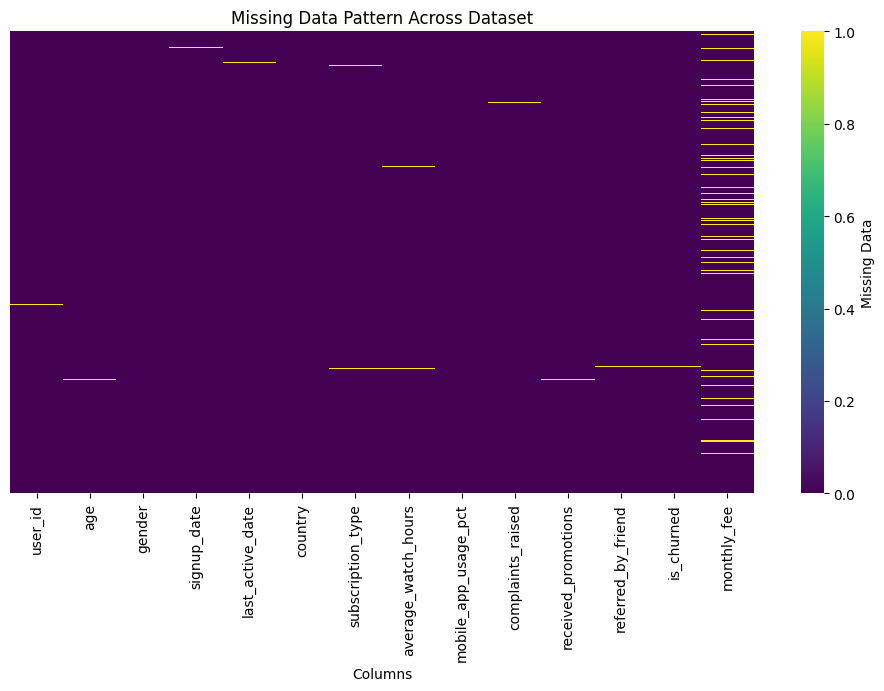

In [13]:
# Visualize missing data pattern
if missing_data.sum() > 0:
  plt.figure(figsize=(12, 6))
  sns.heatmap(df.isnull(), yticklabels=False, cbar=True, cmap='viridis', cbar_kws={'label': 'Missing Data'})
  plt.title('Missing Data Pattern Across Dataset')
  plt.xlabel('Columns')
  plt.tight_layout
  plt.show()

🎯 TARGET VARIABLE ANALYSIS:
Non-churned (0): 1,148 (76.6%)
Churned (1): 351 (23.4%)


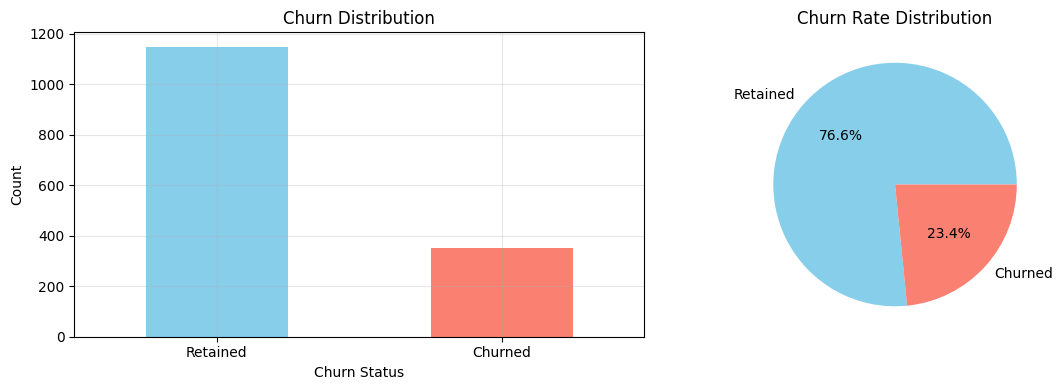

In [14]:
# Target variable distribution
print(f"🎯 TARGET VARIABLE ANALYSIS:")
if 'is_churned' in df.columns:
    churn_counts = df['is_churned'].value_counts()
    churn_rate = df['is_churned'].mean() * 100
    print(f"Non-churned (0): {churn_counts.get(0, 0):,} ({100-churn_rate:.1f}%)")
    print(f"Churned (1): {churn_counts.get(1, 0):,} ({churn_rate:.1f}%)")

    # Visualize target distribution
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    churn_counts.plot(kind='bar', color=['skyblue', 'salmon'])
    plt.title('Churn Distribution')
    plt.xlabel('Churn Status')
    plt.ylabel('Count')
    plt.xticks([0, 1], ['Retained', 'Churned'], rotation=0)
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.pie(churn_counts.values, labels=['Retained', 'Churned'],
            colors=['skyblue', 'salmon'], autopct='%1.1f%%')
    plt.title('Churn Rate Distribution')

    plt.tight_layout()
    plt.show()

# 2. DATA CLEANING AND PREPROCESSING

In [15]:
# Create a copy for cleaning
df_clean = df.copy()
print(f"Created working copy with {df_clean.shape[0]} rows")

Created working copy with 1500 rows


In [16]:
# Remove duplicates
duplicates_removed = df_clean.duplicated().sum()
df_clean = df_clean.drop_duplicates()
print(f"✅ Removed {duplicates_removed} duplicate records")

✅ Removed 0 duplicate records


In [17]:
# Handle date columns with flexible parsing
print("📅 PROCESSING DATE COLUMNS:")

def parse_dates_robust(date_series, column_name):
    """Robust date parsing for multiple formats"""
    parsed_dates = []
    failed_parsing = 0

    for date_str in date_series:
        if pd.isna(date_str) or date_str == '':
            parsed_dates.append(pd.NaT)
            continue

        try:
            # Common date formats to try
            formats_to_try = [
                '%d-%m-%y',     # 13-07-25
                '%d/%m/%Y',     # 13/07/2025
                '%Y-%m-%d',     # 2025-07-13
                '%m/%d/%Y',     # 07/13/2025
                '%d-%m-%Y',     # 13-07-2025
                '%d/%m/%y',     # 13/07/25
                '%m-%d-%Y',     # 07-13-2025
                '%Y/%m/%d'      # 2025/07/13
            ]

            parsed = False
            for fmt in formats_to_try:
                try:
                    parsed_date = pd.to_datetime(str(date_str).strip(), format=fmt)
                    # Handle 2-digit years (assume 2000-2030 range)
                    if parsed_date.year > 2030:
                        parsed_date = parsed_date.replace(year=parsed_date.year - 100)
                    parsed_dates.append(parsed_date)
                    parsed = True
                    break
                except:
                    continue

            if not parsed:
                # Last resort: let pandas try to infer
                parsed_date = pd.to_datetime(str(date_str).strip(), errors='coerce')
                if not pd.isna(parsed_date) and parsed_date.year > 2030:
                    parsed_date = parsed_date.replace(year=parsed_date.year - 100)
                parsed_dates.append(parsed_date)
                if pd.isna(parsed_date):
                    failed_parsing += 1

        except Exception as e:
            parsed_dates.append(pd.NaT)
            failed_parsing += 1

    print(f"  {column_name}: {failed_parsing} dates failed to parse")
    return pd.Series(parsed_dates)

# Parse date columns
if 'signup_date' in df_clean.columns:
    df_clean['signup_date'] = parse_dates_robust(df_clean['signup_date'], 'signup_date')
    print(f"  signup_date range: {df_clean['signup_date'].min()} to {df_clean['signup_date'].max()}")

if 'last_active_date' in df_clean.columns:
    df_clean['last_active_date'] = parse_dates_robust(df_clean['last_active_date'], 'last_active_date')
    print(f"  last_active_date range: {df_clean['last_active_date'].min()} to {df_clean['last_active_date'].max()}")

📅 PROCESSING DATE COLUMNS:
  signup_date: 0 dates failed to parse
  signup_date range: 2022-07-14 00:00:00 to 2025-07-12 00:00:00
  last_active_date: 0 dates failed to parse
  last_active_date range: 2025-07-13 00:00:00 to 2025-07-13 00:00:00


# 3. FEATURE ENGINEERING

## HANDLE MISSING VALUES

In [18]:
# Create new features as specified in the project brief
print("🔧 CREATING REQUIRED FEATURES:")

# Feature 1: tenure_days = days between signup and last_active_date
if 'signup_date' in df_clean.columns and 'last_active_date' in df_clean.columns:
    df_clean['tenure_days'] = (df_clean['last_active_date'] - df_clean['signup_date']).dt.days
    # Handle negative tenure (data quality issues)
    df_clean['tenure_days'] = df_clean['tenure_days'].clip(lower=0)
    print(f"✅ Created tenure_days (mean: {df_clean['tenure_days'].mean():.1f} days)")

# Feature 2: is_loyal = tenure_days > 180
if 'tenure_days' in df_clean.columns:
    df_clean['is_loyal'] = (df_clean['tenure_days'] > 180).astype(int)
    loyal_count = df_clean['is_loyal'].sum()
    print(f"✅ Created is_loyal ({loyal_count} loyal customers, {loyal_count/len(df_clean)*100:.1f}%)")

# watch_per_fee_ratio
if all(col in df_clean.columns for col in ['average_watch_hours', 'monthly_fee']):
    df_clean['watch_per_fee_ratio'] = df_clean['average_watch_hours'] / (df_clean['monthly_fee'] + 0.1)  # Avoid division by zero
    print(f"✅ Created watch_per_fee_ratio (mean: {df_clean['watch_per_fee_ratio'].mean():.2f})")

# heavy_mobile_user (>70% mobile usage)
if 'mobile_app_usage_pct' in df_clean.columns:
    df_clean['heavy_mobile_user'] = (df_clean['mobile_app_usage_pct'] > 70).astype(int)
    heavy_mobile_count = df_clean['heavy_mobile_user'].sum()
    print(f"✅ Created heavy_mobile_user ({heavy_mobile_count} users, {heavy_mobile_count/len(df_clean)*100:.1f}%)")

# Days since last activity (recency)
reference_date = pd.to_datetime('2025-07-13')  # Based on the last_active_date pattern
if 'last_active_date' in df_clean.columns:
    df_clean['days_since_last_active'] = (reference_date - df_clean['last_active_date']).dt.days
    df_clean['days_since_last_active'] = df_clean['days_since_last_active'].clip(lower=0)
    print(f"✅ Created days_since_last_active (mean: {df_clean['days_since_last_active'].mean():.1f} days)")

# Age bins
if 'age' in df_clean.columns:
    df_clean['age_group'] = pd.cut(df_clean['age'],
                                   bins=[0, 25, 35, 50, 65, 100],
                                   labels=['18-25', '26-35', '36-50', '51-65', '65+'])
    print(f"✅ Created age_group bins")

# Watch time bins
if 'average_watch_hours' in df_clean.columns:
    df_clean['watch_time_category'] = pd.cut(df_clean['average_watch_hours'],
                                             bins=[0, 10, 30, 60, 100],
                                             labels=['Low', 'Medium', 'High', 'Very High'])
    print(f"✅ Created watch_time_category bins")

# Interaction feature: received_promotions AND low_watch_time
if all(col in df_clean.columns for col in ['received_promotions', 'average_watch_hours']):
    low_watch_threshold = df_clean['average_watch_hours'].quantile(0.25)
    df_clean['promo_low_watch'] = ((df_clean['received_promotions'] == 'Yes') &
                                   (df_clean['average_watch_hours'] <= low_watch_threshold)).astype(int)
    print(f"✅ Created interaction feature: promo_low_watch")

🔧 CREATING REQUIRED FEATURES:
✅ Created tenure_days (mean: 540.0 days)
✅ Created is_loyal (1237 loyal customers, 82.5%)
✅ Created watch_per_fee_ratio (mean: 4.39)
✅ Created heavy_mobile_user (477 users, 31.8%)
✅ Created days_since_last_active (mean: 0.0 days)
✅ Created age_group bins
✅ Created watch_time_category bins
✅ Created interaction feature: promo_low_watch


In [19]:
# Check current missing values
current_missing = df_clean.isnull().sum()
print(f"Current missing values per column:")
for col, missing_count in current_missing[current_missing > 0].items():
    print(f"  {col}: {missing_count} ({missing_count/len(df_clean)*100:.1f}%)")

Current missing values per column:
  user_id: 2 (0.1%)
  age: 3 (0.2%)
  gender: 1 (0.1%)
  signup_date: 2 (0.1%)
  last_active_date: 2 (0.1%)
  country: 3 (0.2%)
  subscription_type: 3 (0.2%)
  average_watch_hours: 4 (0.3%)
  mobile_app_usage_pct: 2 (0.1%)
  complaints_raised: 3 (0.2%)
  received_promotions: 3 (0.2%)
  referred_by_friend: 3 (0.2%)
  is_churned: 1 (0.1%)
  monthly_fee: 145 (9.7%)
  tenure_days: 4 (0.3%)
  watch_per_fee_ratio: 149 (9.9%)
  days_since_last_active: 2 (0.1%)
  age_group: 3 (0.2%)
  watch_time_category: 4 (0.3%)


In [20]:
# 1. CRITICAL COLUMNS - Drop rows if missing (Target variable)
print("\n1️⃣ HANDLING CRITICAL COLUMNS:")
critical_cols = ['is_churned']
for col in critical_cols:
    if col in df_clean.columns:
        missing_before = df_clean[col].isnull().sum()
        if missing_before > 0:
            df_clean = df_clean.dropna(subset=[col])
            print(f"✅ Dropped {missing_before} rows with missing {col} (target variable)")

# 2. IDENTIFIER COLUMNS - Handle user_id
print("\n2️⃣ HANDLING IDENTIFIER COLUMNS:")
if 'user_id' in df_clean.columns:
    missing_user_ids = df_clean['user_id'].isnull().sum()
    if missing_user_ids > 0:
        print(f"⚠️ Found {missing_user_ids} rows with missing user_id")
        # Option 1: Drop rows (recommended for small numbers)
        if missing_user_ids <= 5:
            df_clean = df_clean.dropna(subset=['user_id'])
            print(f"✅ Dropped {missing_user_ids} rows with missing user_id")
        else:
            # Option 2: Generate synthetic IDs
            max_id = df_clean['user_id'].dropna().max()
            missing_mask = df_clean['user_id'].isnull()
            new_ids = range(int(max_id) + 1, int(max_id) + 1 + missing_user_ids)
            df_clean.loc[missing_mask, 'user_id'] = list(new_ids)
            print(f"✅ Generated {missing_user_ids} new user_ids starting from {int(max_id) + 1}")

# 3. DATE COLUMNS - Handle signup_date and last_active_date
print("\n3️⃣ HANDLING DATE COLUMNS:")

# Handle missing signup_date
if 'signup_date' in df_clean.columns:
    missing_signup = df_clean['signup_date'].isnull().sum()
    if missing_signup > 0:
        print(f"📅 Found {missing_signup} missing signup_date values")
        # Estimate based on tenure if available, otherwise use median date
        if 'tenure_days' in df_clean.columns:
            # Use last_active_date - tenure_days
            reference_date = pd.to_datetime('2025-07-13')
            for idx in df_clean[df_clean['signup_date'].isnull()].index:
                if not pd.isnull(df_clean.loc[idx, 'tenure_days']):
                    estimated_signup = reference_date - pd.Timedelta(days=df_clean.loc[idx, 'tenure_days'])
                    df_clean.loc[idx, 'signup_date'] = estimated_signup.strftime('%d-%m-%y')

        # Fill any remaining missing with median signup date
        remaining_missing = df_clean['signup_date'].isnull().sum()
        if remaining_missing > 0:
            # Convert existing dates and find median
            temp_dates = pd.to_datetime(df_clean['signup_date'].dropna(), errors='coerce')
            median_date = temp_dates.median()
            df_clean['signup_date'].fillna(median_date.strftime('%d-%m-%y'), inplace=True)
            print(f"✅ Filled {missing_signup} missing signup_date values")

# Handle missing last_active_date
if 'last_active_date' in df_clean.columns:
    missing_last_active = df_clean['last_active_date'].isnull().sum()
    if missing_last_active > 0:
        df_clean['last_active_date'].fillna('13-07-25', inplace=True)
        print(f"✅ Filled {missing_last_active} missing last_active_date with '13-07-25'")

# 4. DEMOGRAPHIC COLUMNS
print("\n4️⃣ HANDLING DEMOGRAPHIC DATA:")

# Age
if 'age' in df_clean.columns:
    missing_age = df_clean['age'].isnull().sum()
    if missing_age > 0:
        age_median = df_clean['age'].median()
        df_clean['age'].fillna(age_median, inplace=True)
        print(f"✅ Filled {missing_age} missing age values with median: {age_median:.0f}")

# Gender
if 'gender' in df_clean.columns:
    missing_gender = df_clean['gender'].isnull().sum()
    if missing_gender > 0:
        if missing_gender / len(df_clean) < 0.05:  # Less than 5%
            gender_mode = df_clean['gender'].mode().iloc[0] if not df_clean['gender'].mode().empty else 'Other'
            df_clean['gender'].fillna(gender_mode, inplace=True)
            print(f"✅ Filled {missing_gender} missing gender values with mode: '{gender_mode}'")
        else:
            df_clean['gender'].fillna('Unknown', inplace=True)
            print(f"✅ Filled {missing_gender} missing gender values with 'Unknown'")

# Country
if 'country' in df_clean.columns:
    missing_country = df_clean['country'].isnull().sum()
    if missing_country > 0:
        country_mode = df_clean['country'].mode().iloc[0] if not df_clean['country'].mode().empty else 'Unknown'
        df_clean['country'].fillna(country_mode, inplace=True)
        print(f"✅ Filled {missing_country} missing country values with mode: '{country_mode}'")

# 5. SUBSCRIPTION & BILLING DATA
print("\n5️⃣ HANDLING SUBSCRIPTION & BILLING:")

# Subscription type
if 'subscription_type' in df_clean.columns:
    missing_sub_type = df_clean['subscription_type'].isnull().sum()
    if missing_sub_type > 0:
        sub_type_mode = df_clean['subscription_type'].mode().iloc[0] if not df_clean['subscription_type'].mode().empty else 'Basic'
        df_clean['subscription_type'].fillna(sub_type_mode, inplace=True)
        print(f"✅ Filled {missing_sub_type} missing subscription_type with mode: '{sub_type_mode}'")

# Monthly fee - context-aware imputation based on subscription type
if 'monthly_fee' in df_clean.columns:
    missing_fee = df_clean['monthly_fee'].isnull().sum()
    if missing_fee > 0:
        print(f"💰 Handling {missing_fee} missing monthly_fee values:")

        # Calculate median fee for each subscription type
        fee_by_type = df_clean.groupby('subscription_type')['monthly_fee'].median()
        print("  Median fees by subscription type:")
        for sub_type, median_fee in fee_by_type.items():
            if not pd.isna(median_fee):
                print(f"    {sub_type}: ${median_fee:.2f}")

        # Fill missing fees based on subscription type
        filled_count = 0
        for sub_type in df_clean['subscription_type'].unique():
            if pd.notna(sub_type):
                mask = (df_clean['subscription_type'] == sub_type) & df_clean['monthly_fee'].isnull()
                if mask.sum() > 0:
                    median_fee = fee_by_type.get(sub_type)
                    if pd.notna(median_fee):
                        df_clean.loc[mask, 'monthly_fee'] = median_fee
                        filled_count += mask.sum()
                        print(f"    ✅ Filled {mask.sum()} {sub_type} subscribers with ${median_fee:.2f}")

        # Fill any remaining with overall median
        remaining_missing_fee = df_clean['monthly_fee'].isnull().sum()
        if remaining_missing_fee > 0:
            overall_median = df_clean['monthly_fee'].median()
            df_clean['monthly_fee'].fillna(overall_median, inplace=True)
            print(f"    ✅ Filled {remaining_missing_fee} remaining with overall median: ${overall_median:.2f}")

# 6. USAGE & BEHAVIOR DATA
print("\n6️⃣ HANDLING USAGE & BEHAVIOR:")

# Average watch hours
if 'average_watch_hours' in df_clean.columns:
    missing_watch = df_clean['average_watch_hours'].isnull().sum()
    if missing_watch > 0:
        watch_median = df_clean['average_watch_hours'].median()
        df_clean['average_watch_hours'].fillna(watch_median, inplace=True)
        print(f"✅ Filled {missing_watch} missing average_watch_hours with median: {watch_median:.1f}")

# Mobile app usage
if 'mobile_app_usage_pct' in df_clean.columns:
    missing_mobile = df_clean['mobile_app_usage_pct'].isnull().sum()
    if missing_mobile > 0:
        mobile_median = df_clean['mobile_app_usage_pct'].median()
        df_clean['mobile_app_usage_pct'].fillna(mobile_median, inplace=True)
        print(f"✅ Filled {missing_mobile} missing mobile_app_usage_pct with median: {mobile_median:.1f}%")

# Complaints raised - assume missing means no complaints
if 'complaints_raised' in df_clean.columns:
    missing_complaints = df_clean['complaints_raised'].isnull().sum()
    if missing_complaints > 0:
        df_clean['complaints_raised'].fillna(0, inplace=True)
        print(f"✅ Filled {missing_complaints} missing complaints_raised with 0 (assumed no complaints)")

# 7. MARKETING & REFERRAL DATA
print("\n7️⃣ HANDLING MARKETING & REFERRAL:")

# Received promotions
if 'received_promotions' in df_clean.columns:
    missing_promos = df_clean['received_promotions'].isnull().sum()
    if missing_promos > 0:
        promo_mode = df_clean['received_promotions'].mode().iloc[0] if not df_clean['received_promotions'].mode().empty else 'No'
        df_clean['received_promotions'].fillna(promo_mode, inplace=True)
        print(f"✅ Filled {missing_promos} missing received_promotions with mode: '{promo_mode}'")

# Referred by friend
if 'referred_by_friend' in df_clean.columns:
    missing_referral = df_clean['referred_by_friend'].isnull().sum()
    if missing_referral > 0:
        referral_mode = df_clean['referred_by_friend'].mode().iloc[0] if not df_clean['referred_by_friend'].mode().empty else 'No'
        df_clean['referred_by_friend'].fillna(referral_mode, inplace=True)
        print(f"✅ Filled {missing_referral} missing referred_by_friend with mode: '{referral_mode}'")

# 8. HANDLE ENGINEERED FEATURES
print("\n8️⃣ HANDLING ENGINEERED FEATURES:")

# Tenure days
if 'tenure_days' in df_clean.columns:
    missing_tenure = df_clean['tenure_days'].isnull().sum()
    if missing_tenure > 0:
        # If signup_date or last_active_date was missing, recalculate tenure
        df_clean['tenure_days'].fillna(0, inplace=True)  # Conservative approach
        print(f"✅ Filled {missing_tenure} missing tenure_days with 0")

# Watch per fee ratio
if 'watch_per_fee_ratio' in df_clean.columns:
    missing_ratio = df_clean['watch_per_fee_ratio'].isnull().sum()
    if missing_ratio > 0:
        # Recalculate if both components are now available
        mask = df_clean['watch_per_fee_ratio'].isnull()
        if mask.sum() > 0:
            df_clean.loc[mask, 'watch_per_fee_ratio'] = (
                df_clean.loc[mask, 'average_watch_hours'] /
                (df_clean.loc[mask, 'monthly_fee'] + 0.1)
            )
        print(f"✅ Recalculated {missing_ratio} missing watch_per_fee_ratio values")

# Days since last active
if 'days_since_last_active' in df_clean.columns:
    missing_days = df_clean['days_since_last_active'].isnull().sum()
    if missing_days > 0:
        df_clean['days_since_last_active'].fillna(0, inplace=True)
        print(f"✅ Filled {missing_days} missing days_since_last_active with 0")

# Age group (categorical)
if 'age_group' in df_clean.columns:
    missing_age_group = df_clean['age_group'].isnull().sum()
    if missing_age_group > 0:
        # Recalculate age groups if age is now available
        df_clean['age_group'] = pd.cut(df_clean['age'],
                                       bins=[0, 25, 35, 50, 65, 100],
                                       labels=['18-25', '26-35', '36-50', '51-65', '65+'])
        print(f"✅ Recalculated age_group bins")

# Watch time category
if 'watch_time_category' in df_clean.columns:
    missing_watch_cat = df_clean['watch_time_category'].isnull().sum()
    if missing_watch_cat > 0:
        # Recalculate watch time categories
        df_clean['watch_time_category'] = pd.cut(df_clean['average_watch_hours'],
                                                 bins=[0, 10, 30, 60, 100],
                                                 labels=['Low', 'Medium', 'High', 'Very High'])
        print(f"✅ Recalculated watch_time_category bins")

# Heavy mobile user
if 'heavy_mobile_user' in df_clean.columns:
    missing_heavy_mobile = df_clean['heavy_mobile_user'].isnull().sum()
    if missing_heavy_mobile > 0:
        df_clean['heavy_mobile_user'] = (df_clean['mobile_app_usage_pct'] > 70).astype(int)
        print(f"✅ Recalculated heavy_mobile_user flags")

# Is loyal
if 'is_loyal' in df_clean.columns:
    missing_loyal = df_clean['is_loyal'].isnull().sum()
    if missing_loyal > 0:
        df_clean['is_loyal'] = (df_clean['tenure_days'] > 180).astype(int)
        print(f"✅ Recalculated is_loyal flags")

# Promo low watch interaction
if 'promo_low_watch' in df_clean.columns:
    missing_promo_low = df_clean['promo_low_watch'].isnull().sum()
    if missing_promo_low > 0:
        low_watch_threshold = df_clean['average_watch_hours'].quantile(0.25)
        df_clean['promo_low_watch'] = ((df_clean['received_promotions'] == 'Yes') &
                                       (df_clean['average_watch_hours'] <= low_watch_threshold)).astype(int)
        print(f"✅ Recalculated promo_low_watch interaction feature")


1️⃣ HANDLING CRITICAL COLUMNS:
✅ Dropped 1 rows with missing is_churned (target variable)

2️⃣ HANDLING IDENTIFIER COLUMNS:
⚠️ Found 2 rows with missing user_id
✅ Dropped 2 rows with missing user_id

3️⃣ HANDLING DATE COLUMNS:
📅 Found 2 missing signup_date values
✅ Filled 2 missing signup_date values
✅ Filled 2 missing last_active_date with '13-07-25'

4️⃣ HANDLING DEMOGRAPHIC DATA:
✅ Filled 3 missing age values with median: 44
✅ Filled 1 missing gender values with mode: 'Female'
✅ Filled 3 missing country values with mode: 'Canada'

5️⃣ HANDLING SUBSCRIPTION & BILLING:
✅ Filled 3 missing subscription_type with mode: 'Basic'
💰 Handling 145 missing monthly_fee values:
  Median fees by subscription type:
    Basic: $5.99
    Premium: $13.99
    Standard: $9.99
    ✅ Filled 54 Standard subscribers with $9.99
    ✅ Filled 41 Basic subscribers with $5.99
    ✅ Filled 50 Premium subscribers with $13.99

6️⃣ HANDLING USAGE & BEHAVIOR:
✅ Filled 4 missing average_watch_hours with median: 40.3


In [21]:
print(f"\nFinal dataset shape: {df_clean.shape}")


Final dataset shape: (1497, 22)


## CORRELATION ANALYSIS

Analyzing correlations for 12 numeric features


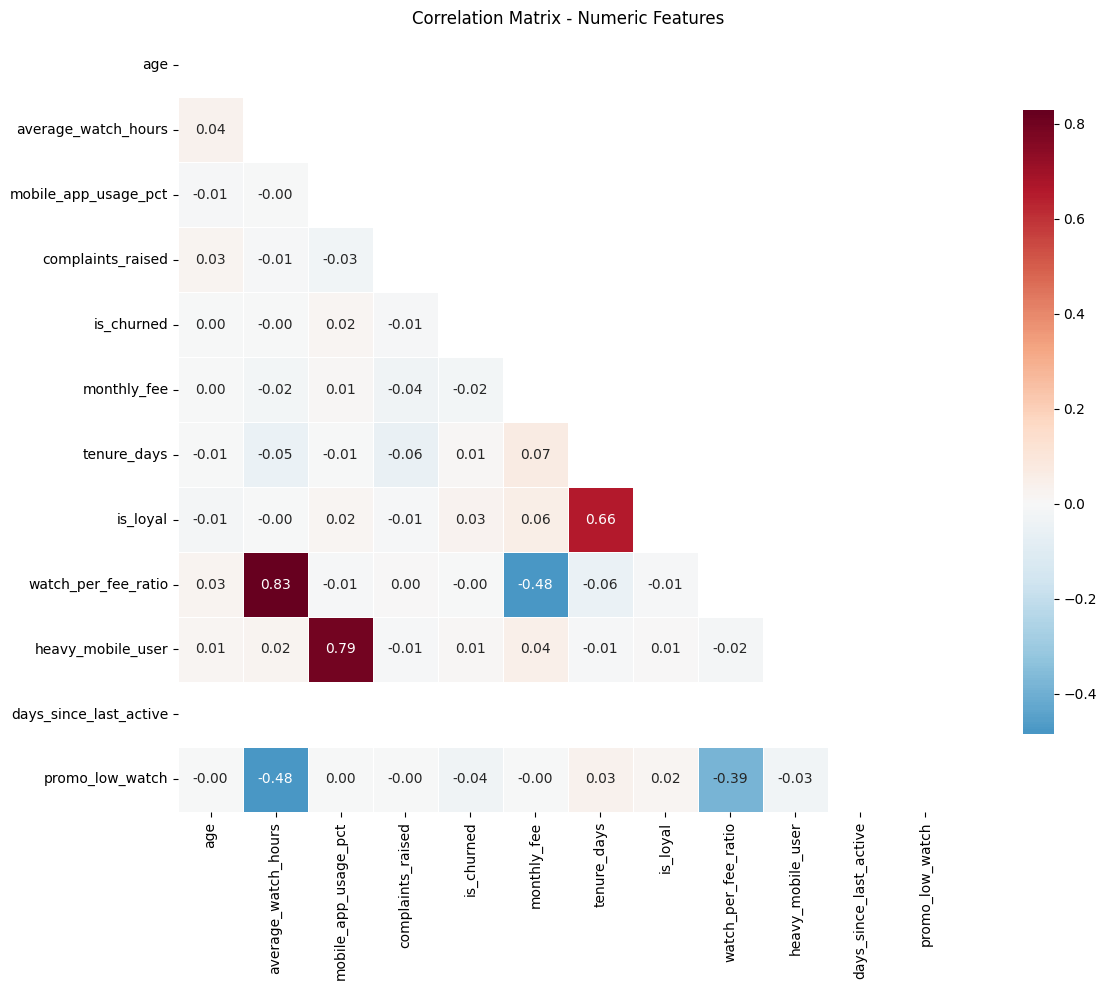


🎯 CORRELATIONS WITH CHURN:
Strongest correlations with churn:
  promo_low_watch: -0.037 (↘️ Negative)
  is_loyal: 0.030 (↗️ Positive)
  monthly_fee: -0.021 (↘️ Negative)
  mobile_app_usage_pct: 0.016 (↗️ Positive)
  heavy_mobile_user: 0.012 (↗️ Positive)
  tenure_days: 0.010 (↗️ Positive)
  complaints_raised: -0.008 (↘️ Negative)
  average_watch_hours: -0.004 (↘️ Negative)
  age: 0.002 (↗️ Positive)


In [22]:
# Select numeric columns for correlation analysis
numeric_features = df_clean.select_dtypes(include=[np.number]).columns.tolist()
if 'user_id' in numeric_features:
    numeric_features.remove('user_id')  # Remove ID column

print(f"Analyzing correlations for {len(numeric_features)} numeric features")

# Calculate correlation matrix
correlation_matrix = df_clean[numeric_features].corr()

# Create correlation heatmap
plt.figure(figsize=(14, 10))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix,
            mask=mask,
            annot=True,
            cmap='RdBu_r',
            center=0,
            square=True,
            linewidths=0.5,
            cbar_kws={"shrink": .8},
            fmt='.2f')
plt.title('Correlation Matrix - Numeric Features')
plt.tight_layout()
plt.show()

# Analyze correlations with target variable
if 'is_churned' in correlation_matrix.columns:
    print("\n🎯 CORRELATIONS WITH CHURN:")
    churn_correlations = correlation_matrix['is_churned'].sort_values(key=abs, ascending=False)
    print("Strongest correlations with churn:")
    for feature, corr in churn_correlations.head(10).items():
        if feature != 'is_churned':
            direction = "↗️ Positive" if corr > 0 else "↘️ Negative"
            print(f"  {feature}: {corr:.3f} ({direction})")

# 4. STATISTICAL ANALYSIS & INSIGHTS

In [23]:
# Chi-square tests for categorical variables
print("🧪 CHI-SQUARE TESTS:")
print("Testing relationship between churn and categorical variables...")

categorical_test_vars = ['gender', 'received_promotions', 'referred_by_friend']
chi_square_results = {}

for var in categorical_test_vars:
    if var in df_clean.columns:
        # Create contingency table
        contingency_table = pd.crosstab(df_clean[var], df_clean['is_churned'])

        # Perform chi-square test
        chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

        # Store results
        chi_square_results[var] = {
            'chi2_statistic': chi2_stat,
            'p_value': p_value,
            'degrees_of_freedom': dof,
            'significant': p_value < 0.05
        }

        print(f"\n{var.upper()}:")
        print(f"  Chi-square statistic: {chi2_stat:.4f}")
        print(f"  P-value: {p_value:.4f}")
        print(f"  Significant at α=0.05: {'✅ Yes' if p_value < 0.05 else '❌ No'}")

        # Show contingency table
        print(f"  Contingency table:")
        print(contingency_table)

🧪 CHI-SQUARE TESTS:
Testing relationship between churn and categorical variables...

GENDER:
  Chi-square statistic: 4.6700
  P-value: 0.0968
  Significant at α=0.05: ❌ No
  Contingency table:
is_churned  0.0  1.0
gender              
Female      374  136
Male        378  104
Other       395  110

RECEIVED_PROMOTIONS:
  Chi-square statistic: 2.4740
  P-value: 0.1157
  Significant at α=0.05: ❌ No
  Contingency table:
is_churned           0.0  1.0
received_promotions          
No                   572  192
Yes                  575  158

REFERRED_BY_FRIEND:
  Chi-square statistic: 0.6404
  P-value: 0.4236
  Significant at α=0.05: ❌ No
  Contingency table:
is_churned          0.0  1.0
referred_by_friend          
No                  563  181
Yes                 584  169


In [24]:
# T-tests for continuous variables
print(f"\n\n🧪 T-TESTS:")
print("Testing differences in means between churned and retained users...")

# Separate churned and retained users
churned_users = df_clean[df_clean['is_churned'] == 1]
retained_users = df_clean[df_clean['is_churned'] == 0]

continuous_test_vars = ['average_watch_hours', 'age', 'mobile_app_usage_pct', 'complaints_raised']
t_test_results = {}

for var in continuous_test_vars:
    if var in df_clean.columns:
        # Get data for both groups
        churned_data = churned_users[var].dropna()
        retained_data = retained_users[var].dropna()

        # Perform independent t-test
        t_stat, p_value = ttest_ind(churned_data, retained_data)

        # Calculate effect size (Cohen's d)
        pooled_std = np.sqrt(((len(churned_data) - 1) * churned_data.var() +
                             (len(retained_data) - 1) * retained_data.var()) /
                            (len(churned_data) + len(retained_data) - 2))
        cohens_d = (churned_data.mean() - retained_data.mean()) / pooled_std

        # Store results
        t_test_results[var] = {
            't_statistic': t_stat,
            'p_value': p_value,
            'churned_mean': churned_data.mean(),
            'retained_mean': retained_data.mean(),
            'effect_size': cohens_d,
            'significant': p_value < 0.05
        }

        print(f"\n{var.upper()}:")
        print(f"  Churned mean: {churned_data.mean():.2f}")
        print(f"  Retained mean: {retained_data.mean():.2f}")
        print(f"  Difference: {churned_data.mean() - retained_data.mean():.2f}")
        print(f"  T-statistic: {t_stat:.4f}")
        print(f"  P-value: {p_value:.4f}")
        print(f"  Effect size (Cohen's d): {cohens_d:.3f}")
        print(f"  Significant at α=0.05: {'✅ Yes' if p_value < 0.05 else '❌ No'}")



🧪 T-TESTS:
Testing differences in means between churned and retained users...

AVERAGE_WATCH_HOURS:
  Churned mean: 39.79
  Retained mean: 39.99
  Difference: -0.19
  T-statistic: -0.1386
  P-value: 0.8898
  Effect size (Cohen's d): -0.008
  Significant at α=0.05: ❌ No

AGE:
  Churned mean: 43.80
  Retained mean: 43.73
  Difference: 0.07
  T-statistic: 0.0741
  P-value: 0.9409
  Effect size (Cohen's d): 0.005
  Significant at α=0.05: ❌ No

MOBILE_APP_USAGE_PCT:
  Churned mean: 52.24
  Retained mean: 51.15
  Difference: 1.09
  T-statistic: 0.6227
  P-value: 0.5336
  Effect size (Cohen's d): 0.038
  Significant at α=0.05: ❌ No

COMPLAINTS_RAISED:
  Churned mean: 2.47
  Retained mean: 2.50
  Difference: -0.03
  T-statistic: -0.3053
  P-value: 0.7602
  Effect size (Cohen's d): -0.019
  Significant at α=0.05: ❌ No


## DATA VISUALIZATION

📊 VISUALIZING CATEGORICAL RELATIONSHIPS:


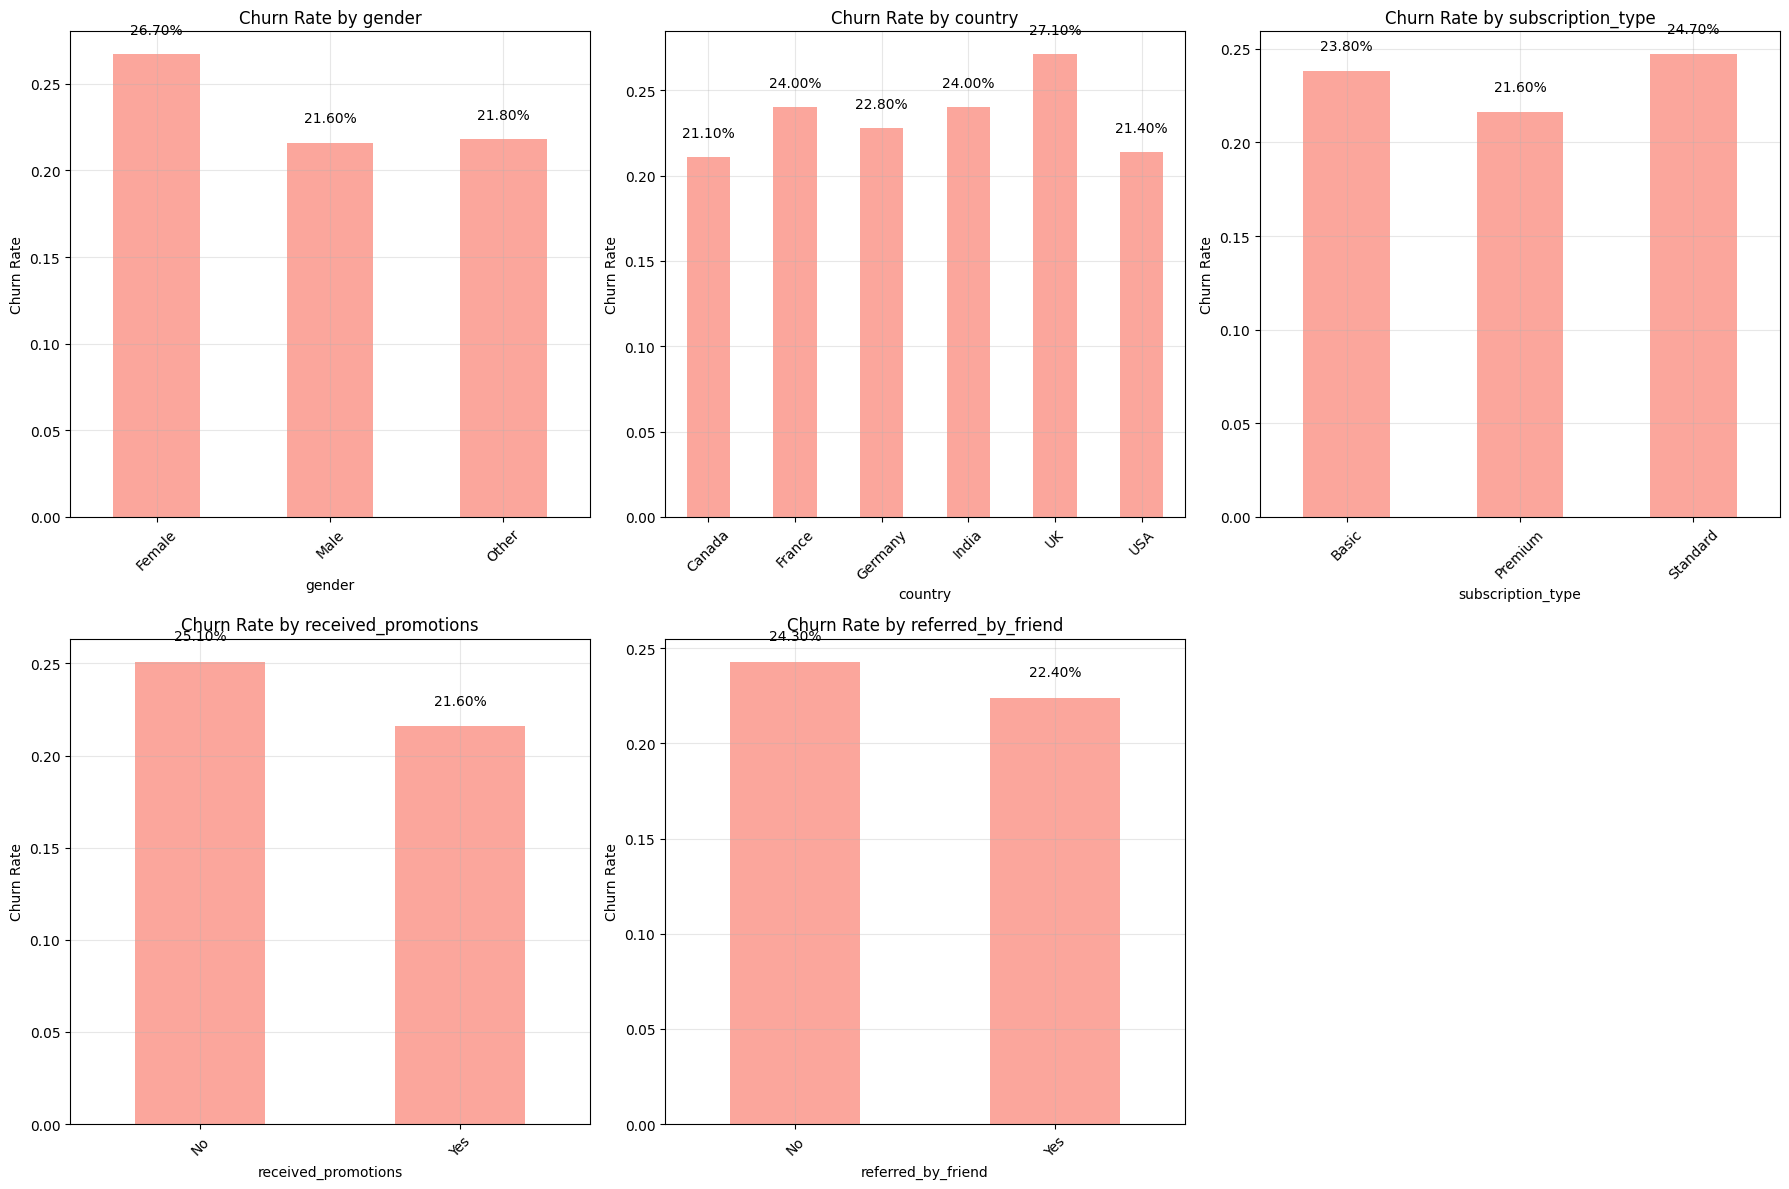

In [25]:
# Categorical variables analysis
print("📊 VISUALIZING CATEGORICAL RELATIONSHIPS:")

categorical_viz_vars = ['gender', 'country', 'subscription_type', 'received_promotions', 'referred_by_friend']
available_cat_vars = [var for var in categorical_viz_vars if var in df_clean.columns]

if available_cat_vars:
    n_vars = min(len(available_cat_vars), 6)  # Limit to 6 for display
    n_cols = 3
    n_rows = (n_vars + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 6*n_rows))
    if n_rows == 1:
        axes = [axes] if n_cols == 1 else axes
    else:
        axes = axes.flatten()

    for i, var in enumerate(available_cat_vars[:n_vars]):
        if i < len(axes):
            # Calculate churn rate by category
            churn_by_category = df_clean.groupby(var)['is_churned'].agg(['count', 'mean']).round(3)

            # Create bar plot
            churn_by_category['mean'].plot(kind='bar', ax=axes[i], color='salmon', alpha=0.7)
            axes[i].set_title(f'Churn Rate by {var}')
            axes[i].set_ylabel('Churn Rate')
            axes[i].tick_params(axis='x', rotation=45)
            axes[i].grid(True, alpha=0.3)

            # Add value labels on bars
            for j, v in enumerate(churn_by_category['mean']):
                axes[i].text(j, v + 0.01, f'{v:.2%}', ha='center', va='bottom')

    # Hide unused subplots
    for i in range(n_vars, len(axes)):
        axes[i].set_visible(False)

    plt.tight_layout()
    plt.show()


📊 VISUALIZING CONTINUOUS RELATIONSHIPS:


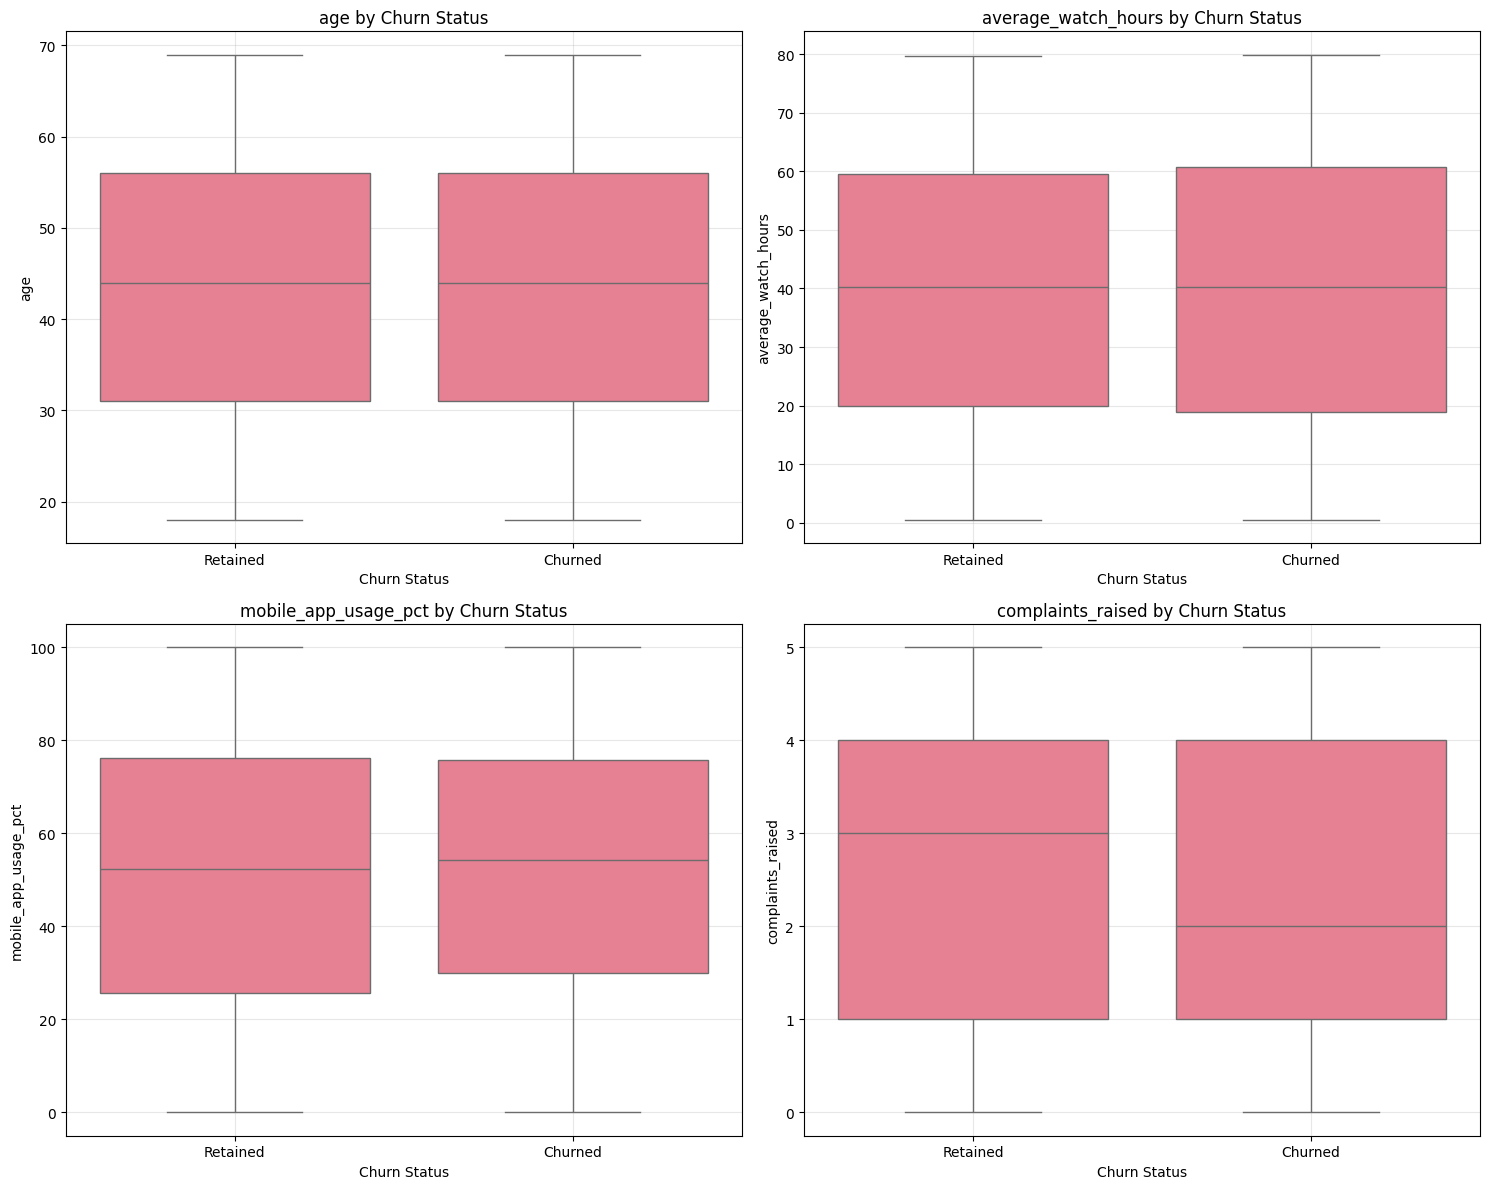

In [26]:
# Continuous variables analysis
print("\n📊 VISUALIZING CONTINUOUS RELATIONSHIPS:")

continuous_viz_vars = ['age', 'average_watch_hours', 'mobile_app_usage_pct', 'complaints_raised']
available_cont_vars = [var for var in continuous_viz_vars if var in df_clean.columns]

if available_cont_vars:
    n_vars = min(len(available_cont_vars), 4)
    n_cols = 2
    n_rows = (n_vars + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 6*n_rows))
    if n_rows == 1:
        axes = [axes] if n_cols == 1 else axes
    else:
        axes = axes.flatten()

    for i, var in enumerate(available_cont_vars[:n_vars]):
        if i < len(axes):
            # Create box plot comparing churned vs retained
            sns.boxplot(data=df_clean, x='is_churned', y=var, ax=axes[i])
            axes[i].set_title(f'{var} by Churn Status')
            axes[i].set_xlabel('Churn Status')
            axes[i].set_xticklabels(['Retained', 'Churned'])
            axes[i].grid(True, alpha=0.3)

    # Hide unused subplots
    for i in range(n_vars, len(axes)):
        axes[i].set_visible(False)

    plt.tight_layout()
    plt.show()

## ENCODE CATEGORICAL VARIABLES FOR MODELING

In [27]:
# Create modeling dataset
df_model = df_clean.copy()
print(f"Created modeling dataset with {df_model.shape[0]} rows and {df_model.shape[1]} columns")

# Remove columns not needed for modeling
columns_to_drop = []
if 'user_id' in df_model.columns:
    columns_to_drop.append('user_id')
if 'signup_date' in df_model.columns:
    columns_to_drop.append('signup_date')
if 'last_active_date' in df_model.columns:
    columns_to_drop.append('last_active_date')

if columns_to_drop:
    df_model = df_model.drop(columns=columns_to_drop)
    print(f"✅ Dropped columns: {columns_to_drop}")

# Identify categorical columns for encoding
categorical_columns = df_model.select_dtypes(include=['object', 'category']).columns.tolist()
print(f"\nCategorical columns to encode: {categorical_columns}")

# Use one-hot encoding (get_dummies) for categorical variables
print(f"\n🔤 APPLYING ONE-HOT ENCODING:")
df_encoded = pd.get_dummies(df_model, columns=categorical_columns, drop_first=True, dtype=int)

print(f"✅ Encoding completed!")
print(f"Shape before encoding: {df_model.shape}")
print(f"Shape after encoding: {df_encoded.shape}")
print(f"New binary features created: {df_encoded.shape[1] - df_model.shape[1]}")

Created modeling dataset with 1497 rows and 22 columns
✅ Dropped columns: ['user_id', 'signup_date', 'last_active_date']

Categorical columns to encode: ['gender', 'country', 'subscription_type', 'received_promotions', 'referred_by_friend', 'age_group', 'watch_time_category']

🔤 APPLYING ONE-HOT ENCODING:
✅ Encoding completed!
Shape before encoding: (1497, 19)
Shape after encoding: (1497, 30)
New binary features created: 11


# 5. PREDICTIVE MODELLING

## LOGISTIC REGRESSION MODEL (BINARY CLASSIFICATION)

📊 MODELING DATASET:
Feature matrix shape: (1497, 29)
Target vector shape: (1497,)
Target distribution: {0.0: 1147, 1.0: 350}

🔄 TRAIN-TEST SPLIT:
Training set: 1197 samples (80.0%)
Test set: 300 samples (20.0%)
Training churn rate: 23.39%
Test churn rate: 23.33%

⚖️ FEATURE SCALING:
✅ Features scaled using StandardScaler

🤖 TRAINING LOGISTIC REGRESSION:
✅ Model training completed

📊 LOGISTIC REGRESSION PERFORMANCE:
Accuracy:  0.7667
Precision: 0.0000
Recall:    0.0000
F1-Score:  0.0000
ROC-AUC:   0.5166

📋 DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

    Retained       0.77      1.00      0.87       230
     Churned       0.00      0.00      0.00        70

    accuracy                           0.77       300
   macro avg       0.38      0.50      0.43       300
weighted avg       0.59      0.77      0.67       300


📊 CONFUSION MATRIX:
[[230   0]
 [ 70   0]]


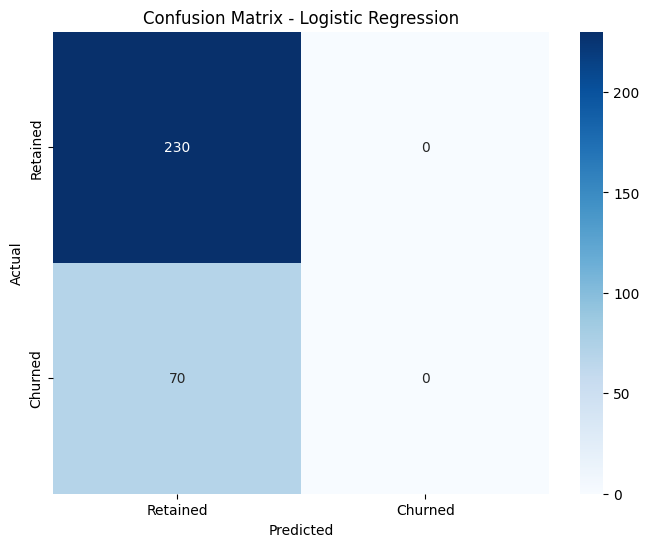


📈 ROC CURVE:


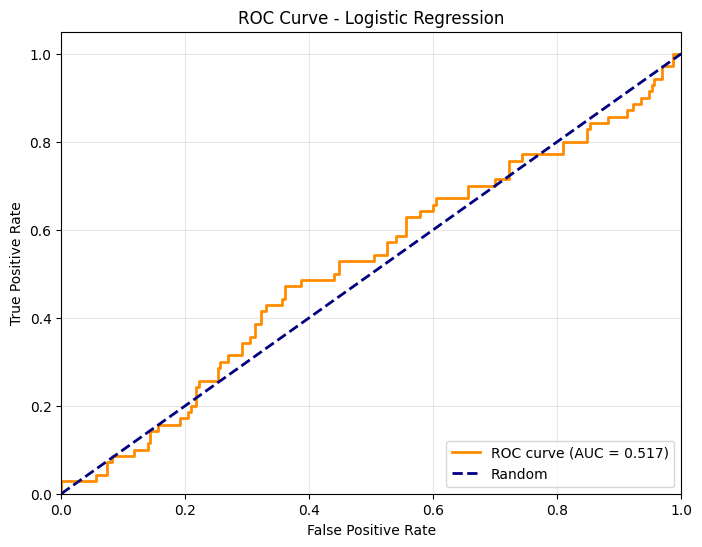


🎯 FEATURE IMPORTANCE ANALYSIS:
Top 15 most important features:
                          feature  coefficient  abs_coefficient
28  watch_time_category_Very High     0.535361         0.535361
1             average_watch_hours    -0.485557         0.485557
25                  age_group_65+     0.289197         0.289197
27       watch_time_category_High     0.287329         0.287329
24                age_group_51-65     0.285155         0.285155
0                             age    -0.255112         0.255112
23                age_group_36-50     0.180908         0.180908
11                    gender_Male    -0.176401         0.176401
12                   gender_Other    -0.170638         0.170638
16                     country_UK     0.137688         0.137688
15                  country_India     0.136777         0.136777
10                promo_low_watch    -0.135106         0.135106
26     watch_time_category_Medium     0.117907         0.117907
13                 country_France     0.

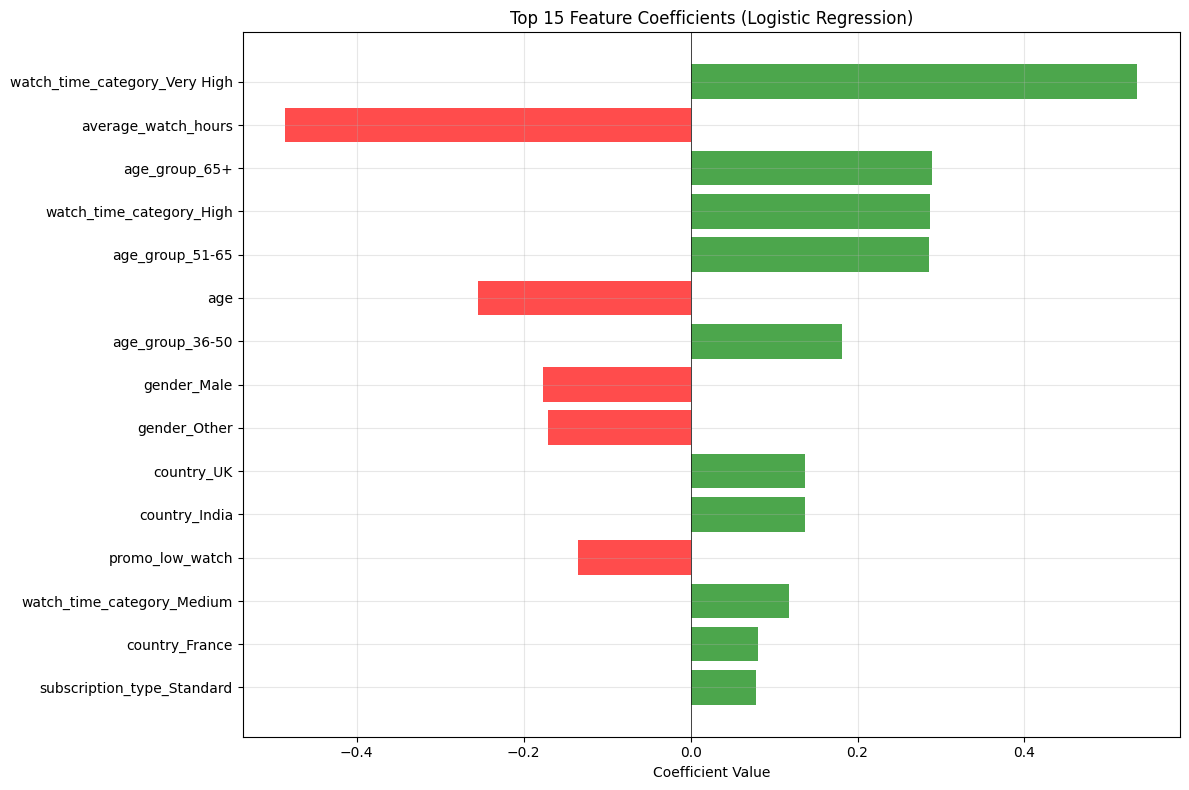

In [28]:
# Prepare features and target
X = df_encoded.drop('is_churned', axis=1)
y = df_encoded['is_churned']

print(f"📊 MODELING DATASET:")
print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")
print(f"Target distribution: {y.value_counts().to_dict()}")

# Train-test split
print(f"\n🔄 TRAIN-TEST SPLIT:")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Test set: {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"Training churn rate: {y_train.mean():.2%}")
print(f"Test churn rate: {y_test.mean():.2%}")

# Feature scaling
print(f"\n⚖️ FEATURE SCALING:")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print(f"✅ Features scaled using StandardScaler")

# Train logistic regression model
print(f"\n🤖 TRAINING LOGISTIC REGRESSION:")
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_scaled, y_train)
print("✅ Model training completed")

# Make predictions
y_pred_lr = lr_model.predict(X_test_scaled)
y_pred_proba_lr = lr_model.predict_proba(X_test_scaled)[:, 1]

# Model evaluation
print(f"\n📊 LOGISTIC REGRESSION PERFORMANCE:")
accuracy = accuracy_score(y_test, y_pred_lr)
precision = precision_score(y_test, y_pred_lr)
recall = recall_score(y_test, y_pred_lr)
f1 = f1_score(y_test, y_pred_lr)
roc_auc = roc_auc_score(y_test, y_pred_proba_lr)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"ROC-AUC:   {roc_auc:.4f}")

# Detailed classification report
print(f"\n📋 DETAILED CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred_lr, target_names=['Retained', 'Churned']))

# Confusion Matrix
print(f"\n📊 CONFUSION MATRIX:")
cm = confusion_matrix(y_test, y_pred_lr)
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Retained', 'Churned'],
            yticklabels=['Retained', 'Churned'])
plt.title('Confusion Matrix - Logistic Regression')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# ROC Curve
print(f"\n📈 ROC CURVE:")
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_lr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

# Feature importance analysis
print(f"\n🎯 FEATURE IMPORTANCE ANALYSIS:")
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'coefficient': lr_model.coef_[0],
    'abs_coefficient': np.abs(lr_model.coef_[0])
}).sort_values('abs_coefficient', ascending=False)

print("Top 15 most important features:")
print(feature_importance.head(15))

# Plot feature importance
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(15)
colors = ['red' if coef < 0 else 'green' for coef in top_features['coefficient']]

plt.barh(range(len(top_features)), top_features['coefficient'], color=colors, alpha=0.7)
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Coefficient Value')
plt.title('Top 15 Feature Coefficients (Logistic Regression)')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## LINEAR REGRESSION MODEL (CONTINUOUS PREDICTION)

🎯 PREDICTING: average_watch_hours
Feature matrix shape: (1497, 28)
Target vector shape: (1497,)

🤖 TRAINING LINEAR REGRESSION:
✅ Linear regression training completed

📊 LINEAR REGRESSION PERFORMANCE:
R² Score: 0.9525
RMSE:     5.0582
MAE:      4.2276

📈 RESIDUAL PLOTS:


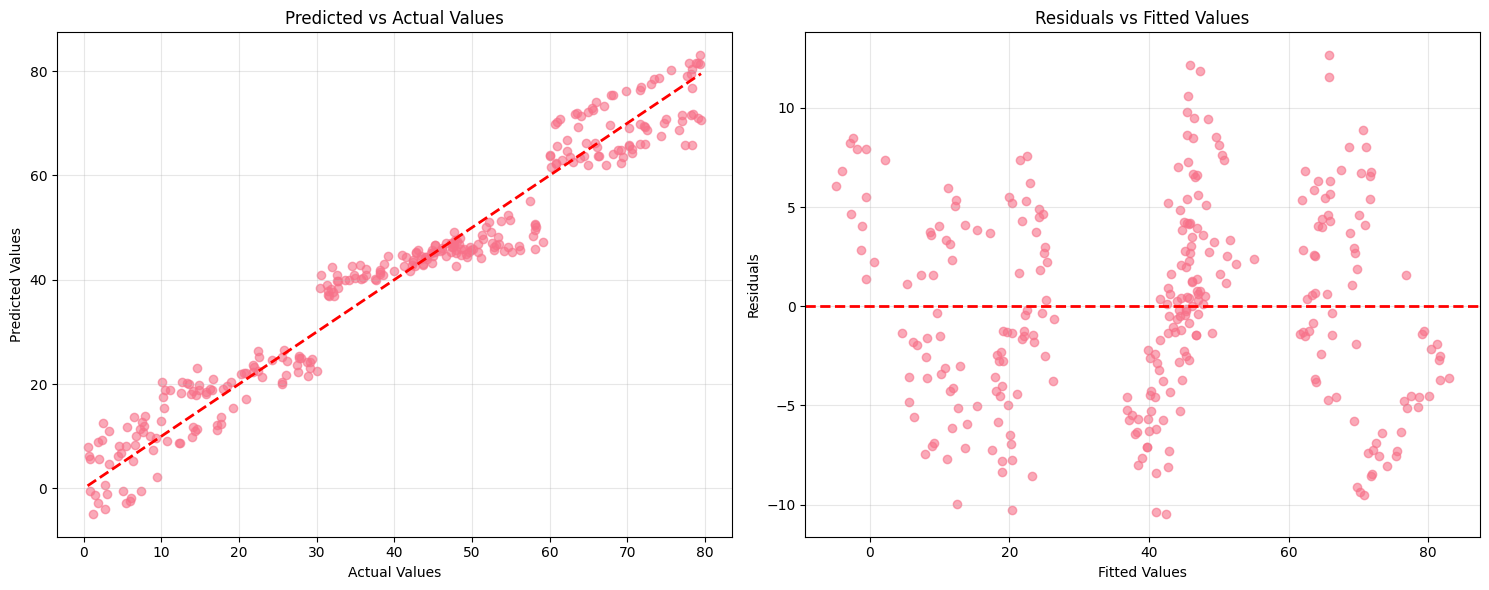


🎯 LINEAR REGRESSION FEATURE IMPORTANCE:
Top 15 most important features for predicting watch hours:
                          feature  coefficient  abs_coefficient
27  watch_time_category_Very High    14.804176        14.804176
6             watch_per_fee_ratio    11.912965        11.912965
26       watch_time_category_High    10.111170        10.111170
3                     monthly_fee     7.685987         7.685987
25     watch_time_category_Medium     2.871675         2.871675
17      subscription_type_Premium    -2.497956         2.497956
9                 promo_low_watch    -1.135297         1.135297
19        received_promotions_Yes     0.640420         0.640420
23                age_group_51-65     0.373254         0.373254
13                country_Germany     0.343507         0.343507
16                    country_USA     0.326144         0.326144
15                     country_UK     0.314625         0.314625
7               heavy_mobile_user     0.293599         0.293599
0   

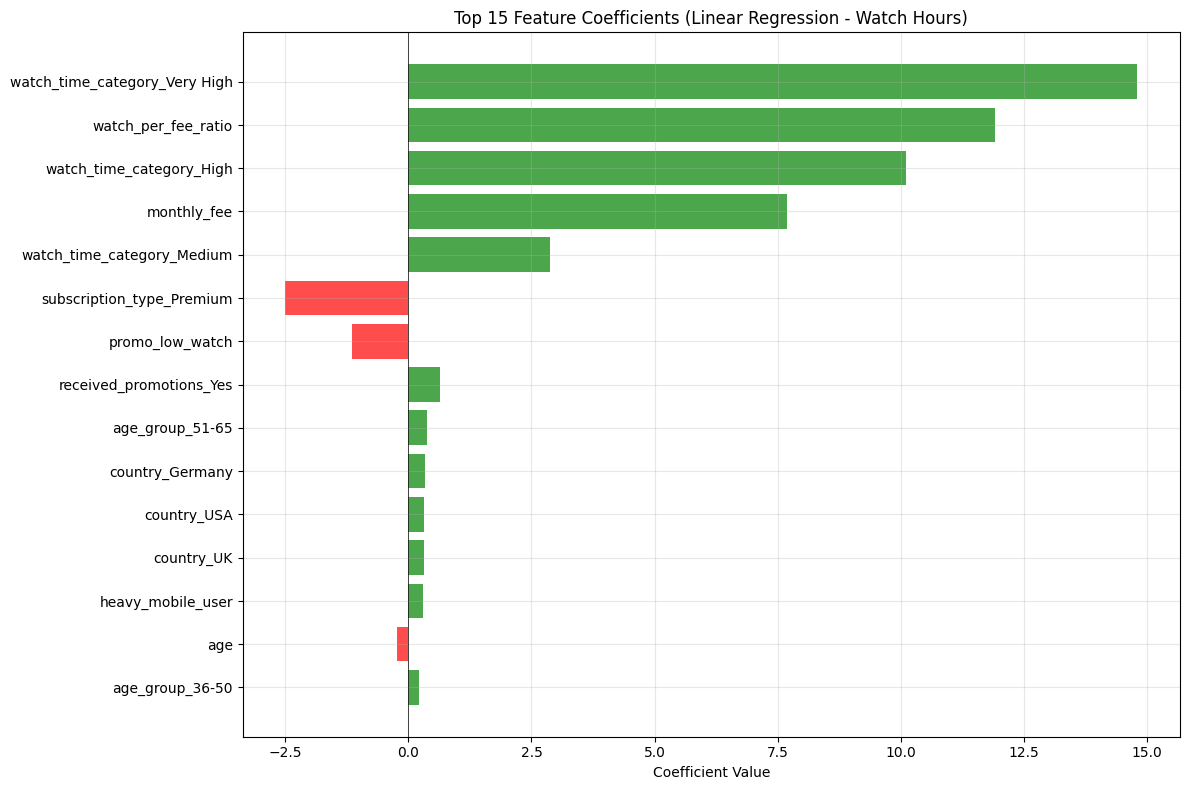

In [29]:
# Choose target variable - let's predict average_watch_hours
target_var = 'average_watch_hours'
print(f"🎯 PREDICTING: {target_var}")

# Prepare features and target for linear regression
X_linear = df_encoded.drop(['is_churned', target_var], axis=1, errors='ignore')
y_linear = df_encoded[target_var]

print(f"Feature matrix shape: {X_linear.shape}")
print(f"Target vector shape: {y_linear.shape}")

# Train-test split for linear regression
X_train_lin, X_test_lin, y_train_lin, y_test_lin = train_test_split(
    X_linear, y_linear, test_size=0.2, random_state=42
)

# Scale features for linear regression
scaler_lin = StandardScaler()
X_train_lin_scaled = scaler_lin.fit_transform(X_train_lin)
X_test_lin_scaled = scaler_lin.transform(X_test_lin)

# Train linear regression model
print(f"\n🤖 TRAINING LINEAR REGRESSION:")
lin_model = LinearRegression()
lin_model.fit(X_train_lin_scaled, y_train_lin)
print("✅ Linear regression training completed")

# Make predictions
y_pred_lin = lin_model.predict(X_test_lin_scaled)

# Model evaluation
print(f"\n📊 LINEAR REGRESSION PERFORMANCE:")
r2 = r2_score(y_test_lin, y_pred_lin)
rmse = np.sqrt(mean_squared_error(y_test_lin, y_pred_lin))
mae = mean_absolute_error(y_test_lin, y_pred_lin)

print(f"R² Score: {r2:.4f}")
print(f"RMSE:     {rmse:.4f}")
print(f"MAE:      {mae:.4f}")

# Residual plots
print(f"\n📈 RESIDUAL PLOTS:")
residuals = y_test_lin - y_pred_lin

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Predicted vs Actual
axes[0].scatter(y_test_lin, y_pred_lin, alpha=0.6)
axes[0].plot([y_test_lin.min(), y_test_lin.max()],
             [y_test_lin.min(), y_test_lin.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Values')
axes[0].set_ylabel('Predicted Values')
axes[0].set_title('Predicted vs Actual Values')
axes[0].grid(True, alpha=0.3)

# Residuals vs Fitted
axes[1].scatter(y_pred_lin, residuals, alpha=0.6)
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Fitted Values')
axes[1].set_ylabel('Residuals')
axes[1].set_title('Residuals vs Fitted Values')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Linear regression feature importance
print(f"\n🎯 LINEAR REGRESSION FEATURE IMPORTANCE:")
lin_feature_importance = pd.DataFrame({
    'feature': X_linear.columns,
    'coefficient': lin_model.coef_,
    'abs_coefficient': np.abs(lin_model.coef_)
}).sort_values('abs_coefficient', ascending=False)

print("Top 15 most important features for predicting watch hours:")
print(lin_feature_importance.head(15))

# Plot linear regression feature importance
plt.figure(figsize=(12, 8))
top_lin_features = lin_feature_importance.head(15)
colors = ['red' if coef < 0 else 'green' for coef in top_lin_features['coefficient']]

plt.barh(range(len(top_lin_features)), top_lin_features['coefficient'], color=colors, alpha=0.7)
plt.yticks(range(len(top_lin_features)), top_lin_features['feature'])
plt.xlabel('Coefficient Value')
plt.title('Top 15 Feature Coefficients (Linear Regression - Watch Hours)')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## HYPERPARAMETER TUNING (STRETCH GOAL)

In [30]:
print("🔧 GRID SEARCH FOR OPTIMAL HYPERPARAMETERS:")

# Define parameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

# Grid search with cross-validation
grid_search = GridSearchCV(
    LogisticRegression(random_state=42, max_iter=1000),
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

grid_search.fit(X_train_scaled, y_train)

print(f"✅ Grid search completed")
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Train best model
best_lr_model = grid_search.best_estimator_
y_pred_best = best_lr_model.predict(X_test_scaled)
y_pred_proba_best = best_lr_model.predict_proba(X_test_scaled)[:, 1]

# Evaluate tuned model
print(f"\n📊 TUNED MODEL PERFORMANCE:")
accuracy_best = accuracy_score(y_test, y_pred_best)
precision_best = precision_score(y_test, y_pred_best)
recall_best = recall_score(y_test, y_pred_best)
f1_best = f1_score(y_test, y_pred_best)
roc_auc_best = roc_auc_score(y_test, y_pred_proba_best)

print(f"Accuracy:  {accuracy_best:.4f} (vs {accuracy:.4f})")
print(f"Precision: {precision_best:.4f} (vs {precision:.4f})")
print(f"Recall:    {recall_best:.4f} (vs {recall:.4f})")
print(f"F1-Score:  {f1_best:.4f} (vs {f1:.4f})")
print(f"ROC-AUC:   {roc_auc_best:.4f} (vs {roc_auc:.4f})")

🔧 GRID SEARCH FOR OPTIMAL HYPERPARAMETERS:
✅ Grid search completed
Best parameters: {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}
Best cross-validation score: 0.5000

📊 TUNED MODEL PERFORMANCE:
Accuracy:  0.7667 (vs 0.7667)
Precision: 0.0000 (vs 0.0000)
Recall:    0.0000 (vs 0.0000)
F1-Score:  0.0000 (vs 0.0000)
ROC-AUC:   0.5000 (vs 0.5166)


## RANDOM FOREST MODEL (STRETCH GOAL)

🌲 TRAINING RANDOM FOREST:
✅ Random Forest training completed

📊 RANDOM FOREST PERFORMANCE:
Accuracy:  0.7633
Precision: 0.3333
Recall:    0.0143
F1-Score:  0.0274
ROC-AUC:   0.5530

🌲 RANDOM FOREST FEATURE IMPORTANCE:
Top 15 most important features:
                    feature  importance
5               tenure_days    0.133315
7       watch_per_fee_ratio    0.124467
2      mobile_app_usage_pct    0.124112
1       average_watch_hours    0.115069
0                       age    0.101631
3         complaints_raised    0.059701
4               monthly_fee    0.040756
21   referred_by_friend_Yes    0.022694
20  received_promotions_Yes    0.021201
12             gender_Other    0.019094
11              gender_Male    0.018684
16               country_UK    0.016593
15            country_India    0.015582
14          country_Germany    0.015518
8         heavy_mobile_user    0.015407


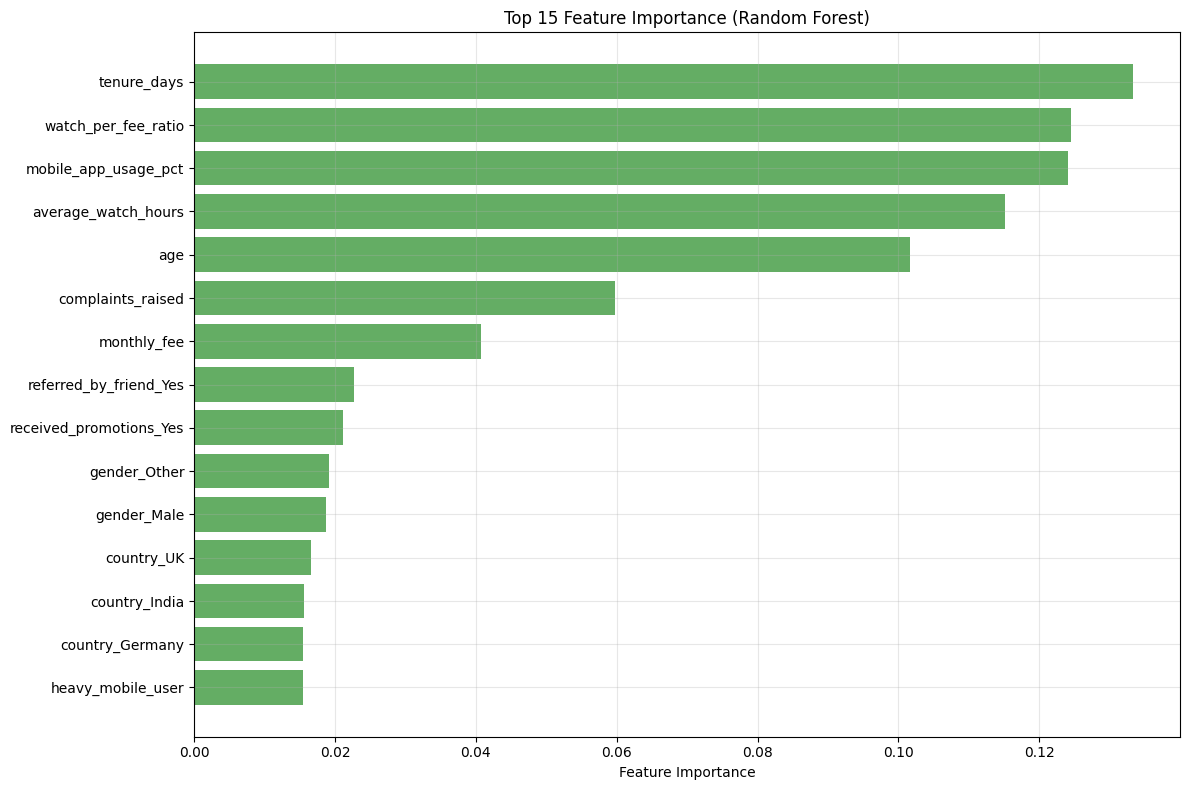

In [31]:
print("🌲 TRAINING RANDOM FOREST:")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)  # Random Forest doesn't require scaling
print("✅ Random Forest training completed")

# Make predictions
y_pred_rf = rf_model.predict(X_test)
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# Evaluate Random Forest
print(f"\n📊 RANDOM FOREST PERFORMANCE:")
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
roc_auc_rf = roc_auc_score(y_test, y_pred_proba_rf)

print(f"Accuracy:  {accuracy_rf:.4f}")
print(f"Precision: {precision_rf:.4f}")
print(f"Recall:    {recall_rf:.4f}")
print(f"F1-Score:  {f1_rf:.4f}")
print(f"ROC-AUC:   {roc_auc_rf:.4f}")

# Random Forest feature importance
print(f"\n🌲 RANDOM FOREST FEATURE IMPORTANCE:")
rf_feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 15 most important features:")
print(rf_feature_importance.head(15))

# Plot Random Forest feature importance
plt.figure(figsize=(12, 8))
top_rf_features = rf_feature_importance.head(15)
plt.barh(range(len(top_rf_features)), top_rf_features['importance'], color='forestgreen', alpha=0.7)
plt.yticks(range(len(top_rf_features)), top_rf_features['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 15 Feature Importance (Random Forest)')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [32]:
# Model comparison
print(f"\n📊 MODEL COMPARISON:")
models_comparison = pd.DataFrame({
    'Model': ['Logistic Regression', 'Tuned Logistic Regression', 'Random Forest'],
    'Accuracy': [accuracy, accuracy_best, accuracy_rf],
    'Precision': [precision, precision_best, precision_rf],
    'Recall': [recall, recall_best, recall_rf],
    'F1-Score': [f1, f1_best, f1_rf],
    'ROC-AUC': [roc_auc, roc_auc_best, roc_auc_rf]
})

print(models_comparison.round(4))


📊 MODEL COMPARISON:
                       Model  Accuracy  Precision  Recall  F1-Score  ROC-AUC
0        Logistic Regression    0.7667     0.0000  0.0000    0.0000   0.5166
1  Tuned Logistic Regression    0.7667     0.0000  0.0000    0.0000   0.5000
2              Random Forest    0.7633     0.3333  0.0143    0.0274   0.5530


# 6. BUSINESS QUESTIONS ANALYSIS


1️⃣ DO USERS WHO RECEIVE PROMOTIONS CHURN LESS?
                     count      mean
received_promotions                 
No                     764  0.251309
Yes                    733  0.215553
Churn rate with promotions: 21.56%
Churn rate without promotions: 25.13%
Difference: 3.58%


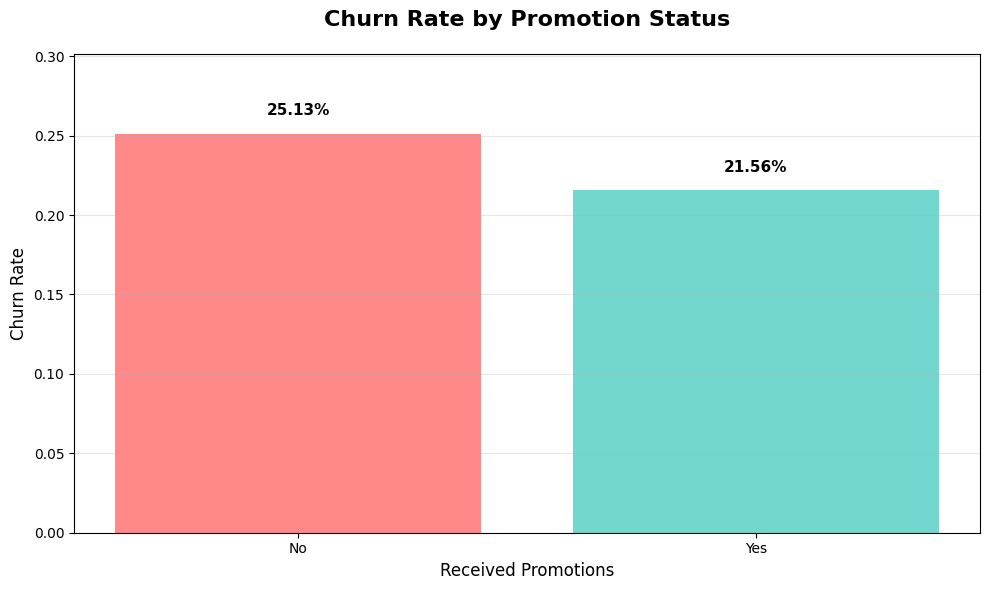

In [33]:
print(f"\n1️⃣ DO USERS WHO RECEIVE PROMOTIONS CHURN LESS?")
if 'received_promotions' in df_clean.columns:
    promo_churn_analysis = df_clean.groupby('received_promotions')['is_churned'].agg(['count', 'mean'])
    print(promo_churn_analysis)

    promo_yes_churn = promo_churn_analysis.loc['Yes', 'mean'] if 'Yes' in promo_churn_analysis.index else 0
    promo_no_churn = promo_churn_analysis.loc['No', 'mean'] if 'No' in promo_churn_analysis.index else 0

    print(f"Churn rate with promotions: {promo_yes_churn:.2%}")
    print(f"Churn rate without promotions: {promo_no_churn:.2%}")
    print(f"Difference: {promo_no_churn - promo_yes_churn:.2%}")

    # VISUALIZATION 1: Promotion vs Churn Rate
    plt.figure(figsize=(10, 6))
    promo_data = promo_churn_analysis['mean']
    bars = plt.bar(promo_data.index, promo_data.values, color=['#FF6B6B', '#4ECDC4'], alpha=0.8)
    plt.title('Churn Rate by Promotion Status', fontsize=16, fontweight='bold', pad=20)
    plt.ylabel('Churn Rate', fontsize=12)
    plt.xlabel('Received Promotions', fontsize=12)
    plt.ylim(0, max(promo_data.values) * 1.2)

    # Add value labels on bars
    for bar, value in zip(bars, promo_data.values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{value:.2%}', ha='center', va='bottom', fontweight='bold', fontsize=11)

    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()


2️⃣ DOES WATCH TIME IMPACT CHURN LIKELIHOOD?
Average watch time - Churned users: 39.8 hours
Average watch time - Retained users: 40.0 hours
Difference: 0.2 hours
Churn rate by watch time quartile:
watch_time_quartile
Q1    0.242667
Q2    0.226064
Q3    0.217158
Q4    0.249330
Name: is_churned, dtype: float64


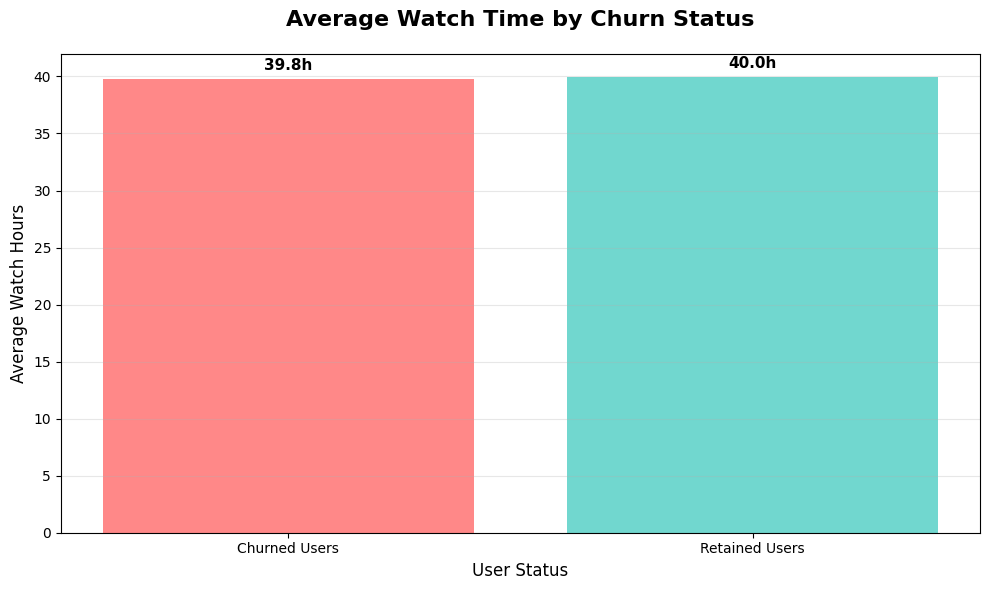

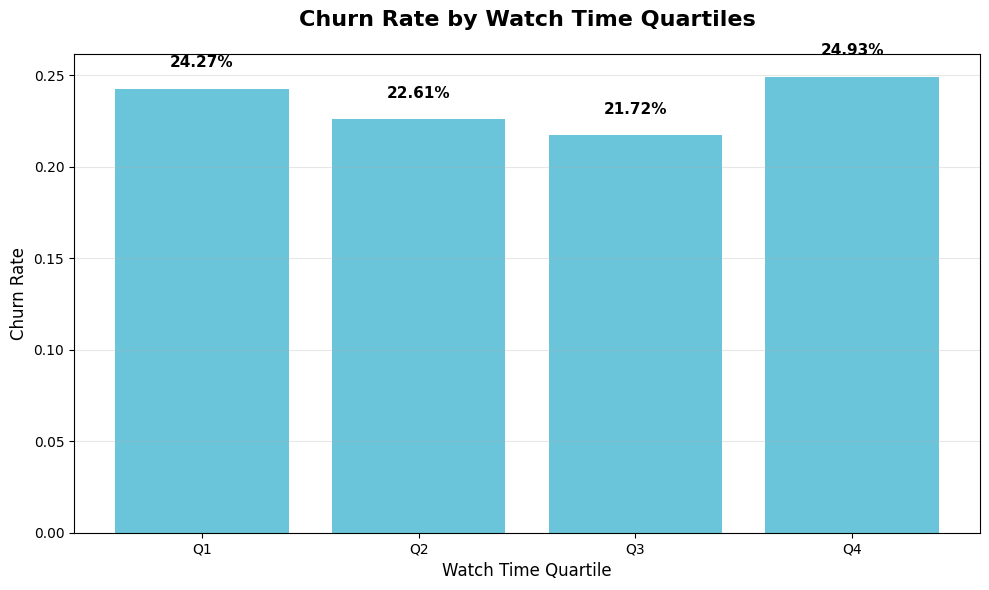

In [34]:
print(f"\n2️⃣ DOES WATCH TIME IMPACT CHURN LIKELIHOOD?")
if 'average_watch_hours' in df_clean.columns:
    churned_watch_time = churned_users['average_watch_hours'].mean()
    retained_watch_time = retained_users['average_watch_hours'].mean()

    print(f"Average watch time - Churned users: {churned_watch_time:.1f} hours")
    print(f"Average watch time - Retained users: {retained_watch_time:.1f} hours")
    print(f"Difference: {retained_watch_time - churned_watch_time:.1f} hours")

    # Watch time quartile analysis
    df_clean['watch_time_quartile'] = pd.qcut(df_clean['average_watch_hours'], 4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
    quartile_churn = df_clean.groupby('watch_time_quartile')['is_churned'].mean()
    print(f"Churn rate by watch time quartile:")
    print(quartile_churn)

    # VISUALIZATION 2A: Average Watch Time by Churn Status
    plt.figure(figsize=(10, 6))
    watch_comparison = [churned_watch_time, retained_watch_time]
    labels = ['Churned Users', 'Retained Users']
    bars = plt.bar(labels, watch_comparison, color=['#FF6B6B', '#4ECDC4'], alpha=0.8)
    plt.title('Average Watch Time by Churn Status', fontsize=16, fontweight='bold', pad=20)
    plt.ylabel('Average Watch Hours', fontsize=12)
    plt.xlabel('User Status', fontsize=12)

    for bar, value in zip(bars, watch_comparison):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                f'{value:.1f}h', ha='center', va='bottom', fontweight='bold', fontsize=11)

    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

    # VISUALIZATION 2B: Churn Rate by Watch Time Quartiles
    plt.figure(figsize=(10, 6))
    bars = plt.bar(quartile_churn.index, quartile_churn.values, color='#45B7D1', alpha=0.8)
    plt.title('Churn Rate by Watch Time Quartiles', fontsize=16, fontweight='bold', pad=20)
    plt.ylabel('Churn Rate', fontsize=12)
    plt.xlabel('Watch Time Quartile', fontsize=12)

    for bar, value in zip(bars, quartile_churn.values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{value:.2%}', ha='center', va='bottom', fontweight='bold', fontsize=11)

    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()


3️⃣ ARE MOBILE DOMINANT USERS MORE LIKELY TO CANCEL?
Mobile usage analysis:
                 count      mean
mobile_dominant                 
0                 1020  0.230392
1                  477  0.241090
Churn rate - Mobile dominant users (>70%): 24.11%
Churn rate - Non-mobile dominant users (≤70%): 23.04%


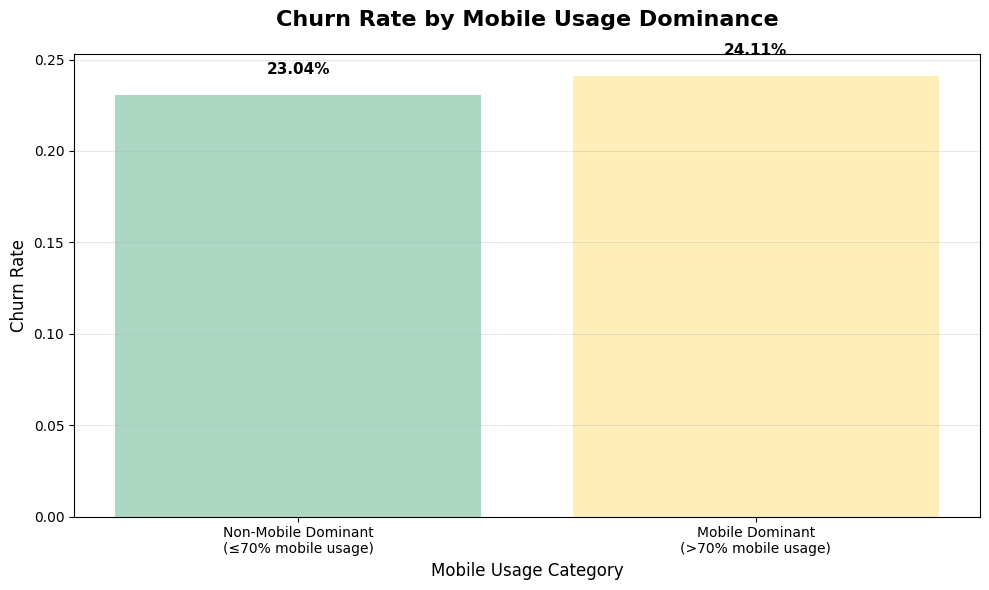

In [35]:
print(f"\n3️⃣ ARE MOBILE DOMINANT USERS MORE LIKELY TO CANCEL?")
if 'mobile_app_usage_pct' in df_clean.columns:
    # Define mobile dominant as >70% mobile usage
    df_clean['mobile_dominant'] = (df_clean['mobile_app_usage_pct'] > 70).astype(int)
    mobile_churn_analysis = df_clean.groupby('mobile_dominant')['is_churned'].agg(['count', 'mean'])

    print("Mobile usage analysis:")
    print(mobile_churn_analysis)

    mobile_dom_churn = mobile_churn_analysis.loc[1, 'mean'] if 1 in mobile_churn_analysis.index else 0
    mobile_non_dom_churn = mobile_churn_analysis.loc[0, 'mean'] if 0 in mobile_churn_analysis.index else 0

    print(f"Churn rate - Mobile dominant users (>70%): {mobile_dom_churn:.2%}")
    print(f"Churn rate - Non-mobile dominant users (≤70%): {mobile_non_dom_churn:.2%}")

    # VISUALIZATION 3: Mobile Dominance vs Churn Rate
    plt.figure(figsize=(10, 6))
    mobile_labels = ['Non-Mobile Dominant\n(≤70% mobile usage)', 'Mobile Dominant\n(>70% mobile usage)']
    mobile_values = [mobile_non_dom_churn, mobile_dom_churn]
    bars = plt.bar(mobile_labels, mobile_values, color=['#96CEB4', '#FFEAA7'], alpha=0.8)
    plt.title('Churn Rate by Mobile Usage Dominance', fontsize=16, fontweight='bold', pad=20)
    plt.ylabel('Churn Rate', fontsize=12)
    plt.xlabel('Mobile Usage Category', fontsize=12)

    for bar, value in zip(bars, mobile_values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{value:.2%}', ha='center', va='bottom', fontweight='bold', fontsize=11)

    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()


4️⃣ TOP 3 FEATURES INFLUENCING CHURN:
Based on Logistic Regression coefficients:
1. watch_time_category_Very High: increases churn likelihood (coef: 0.535)
2. average_watch_hours: decreases churn likelihood (coef: -0.486)
3. age_group_65+: increases churn likelihood (coef: 0.289)


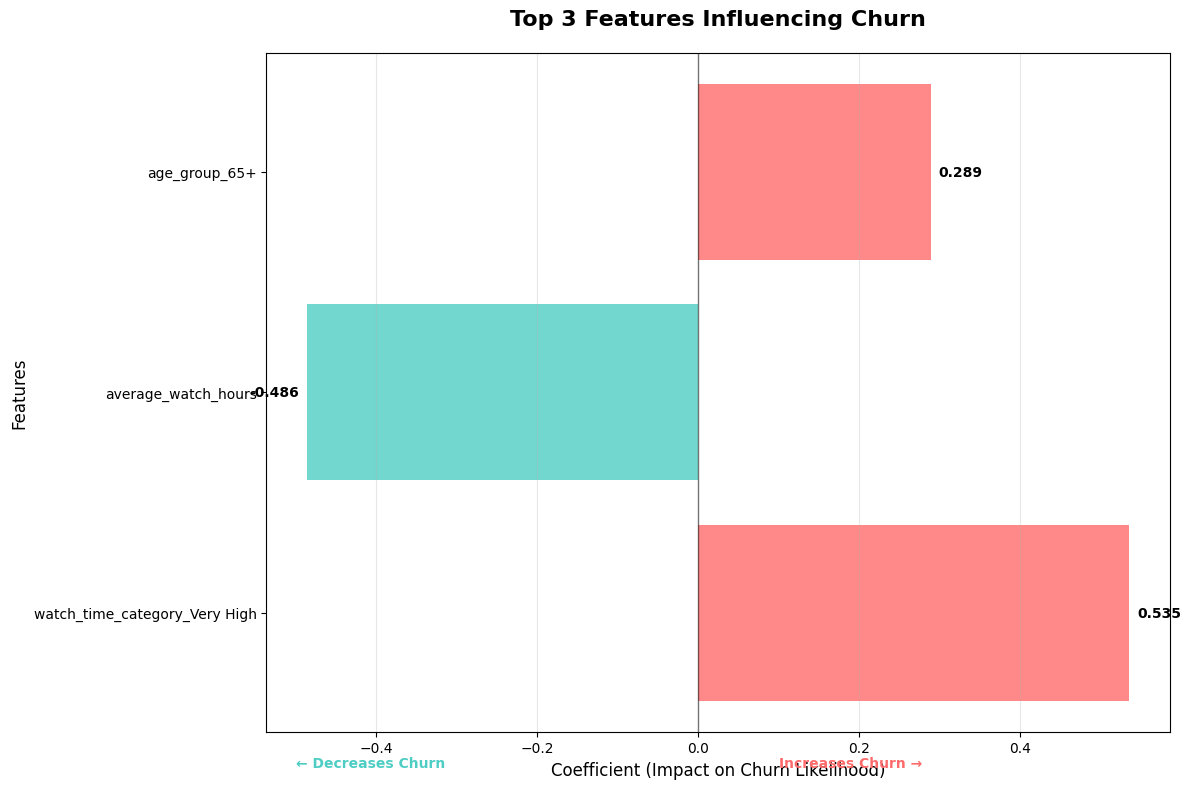

In [36]:
print(f"\n4️⃣ TOP 3 FEATURES INFLUENCING CHURN:")
top_3_features = feature_importance.head(3)
print("Based on Logistic Regression coefficients:")
for i, (_, row) in enumerate(top_3_features.iterrows(), 1):
    direction = "increases" if row['coefficient'] > 0 else "decreases"
    print(f"{i}. {row['feature']}: {direction} churn likelihood (coef: {row['coefficient']:.3f})")

# VISUALIZATION 4: Top Features Influencing Churn
plt.figure(figsize=(12, 8))
colors = ['#FF6B6B' if coef > 0 else '#4ECDC4' for coef in top_3_features['coefficient']]
bars = plt.barh(top_3_features['feature'], top_3_features['coefficient'], color=colors, alpha=0.8)
plt.title('Top 3 Features Influencing Churn', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Coefficient (Impact on Churn Likelihood)', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.axvline(x=0, color='black', linestyle='-', alpha=0.5, linewidth=1)

for bar, value in zip(bars, top_3_features['coefficient']):
    plt.text(value + (0.01 if value > 0 else -0.01), bar.get_y() + bar.get_height()/2,
            f'{value:.3f}', ha='left' if value > 0 else 'right', va='center',
            fontweight='bold', fontsize=10)

# Add legend
plt.text(-0.5, -0.7, '← Decreases Churn', color='#4ECDC4', fontweight='bold', fontsize=10)
plt.text(0.1, -0.7, 'Increases Churn →', color='#FF6B6B', fontweight='bold', fontsize=10)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


5️⃣ CUSTOMER SEGMENTS FOR RETENTION TEAM TO PRIORITIZE:
High-risk customer segments:
1. Low engagement users (<19.5h): 24.27% churn rate (375 customers)
2. High complaint users (≥3 complaints): 22.24% churn rate (742 customers)
3. New users without promotions (≤90 days, no promos): 18.18% churn rate (77 customers)


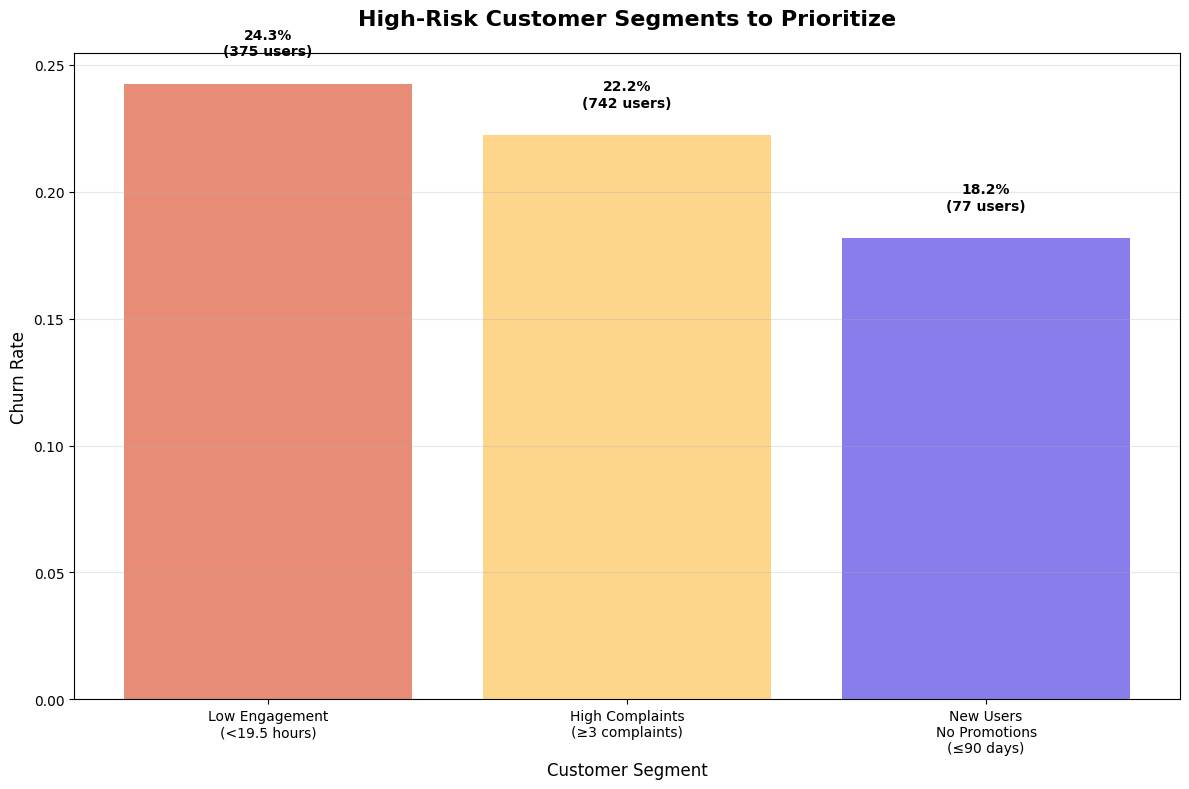

In [37]:
print(f"\n5️⃣ CUSTOMER SEGMENTS FOR RETENTION TEAM TO PRIORITIZE:")

# High-risk segments based on analysis
print("High-risk customer segments:")

segment_data = []

# Segment 1: Low engagement users
if 'average_watch_hours' in df_clean.columns:
    low_watch_threshold = df_clean['average_watch_hours'].quantile(0.25)
    low_engagement = df_clean[df_clean['average_watch_hours'] <= low_watch_threshold]
    low_engagement_churn = low_engagement['is_churned'].mean()
    segment_data.append(('Low Engagement\n(<{:.1f} hours)'.format(low_watch_threshold),
                        low_engagement_churn, len(low_engagement)))
    print(f"1. Low engagement users (<{low_watch_threshold:.1f}h): {low_engagement_churn:.2%} churn rate ({len(low_engagement)} customers)")

# Segment 2: High complaints users
if 'complaints_raised' in df_clean.columns:
    high_complaints = df_clean[df_clean['complaints_raised'] >= 3]
    high_complaints_churn = high_complaints['is_churned'].mean() if len(high_complaints) > 0 else 0
    segment_data.append(('High Complaints\n(≥3 complaints)', high_complaints_churn, len(high_complaints)))
    print(f"2. High complaint users (≥3 complaints): {high_complaints_churn:.2%} churn rate ({len(high_complaints)} customers)")

# Segment 3: New users without promotions
if all(col in df_clean.columns for col in ['tenure_days', 'received_promotions']):
    new_no_promo = df_clean[(df_clean['tenure_days'] <= 90) & (df_clean['received_promotions'] == 'No')]
    new_no_promo_churn = new_no_promo['is_churned'].mean() if len(new_no_promo) > 0 else 0
    segment_data.append(('New Users\nNo Promotions\n(≤90 days)', new_no_promo_churn, len(new_no_promo)))
    print(f"3. New users without promotions (≤90 days, no promos): {new_no_promo_churn:.2%} churn rate ({len(new_no_promo)} customers)")

# VISUALIZATION 5: High-Risk Customer Segments
if segment_data:
    plt.figure(figsize=(12, 8))
    segments, churn_rates, counts = zip(*segment_data)
    bars = plt.bar(segments, churn_rates, color=['#E17055', '#FDCB6E', '#6C5CE7'], alpha=0.8)
    plt.title('High-Risk Customer Segments to Prioritize', fontsize=16, fontweight='bold', pad=20)
    plt.ylabel('Churn Rate', fontsize=12)
    plt.xlabel('Customer Segment', fontsize=12)

    for bar, value, count in zip(bars, churn_rates, counts):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{value:.1%}\n({count} users)', ha='center', va='bottom',
                fontweight='bold', fontsize=10)

    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()


6️⃣ FACTORS AFFECTING WATCH TIME (LINEAR REGRESSION INSIGHTS):
Top 3 factors affecting watch hours:
1. watch_time_category_Very High: increases watch time (coef: 14.804)
2. watch_per_fee_ratio: increases watch time (coef: 11.913)
3. watch_time_category_High: increases watch time (coef: 10.111)


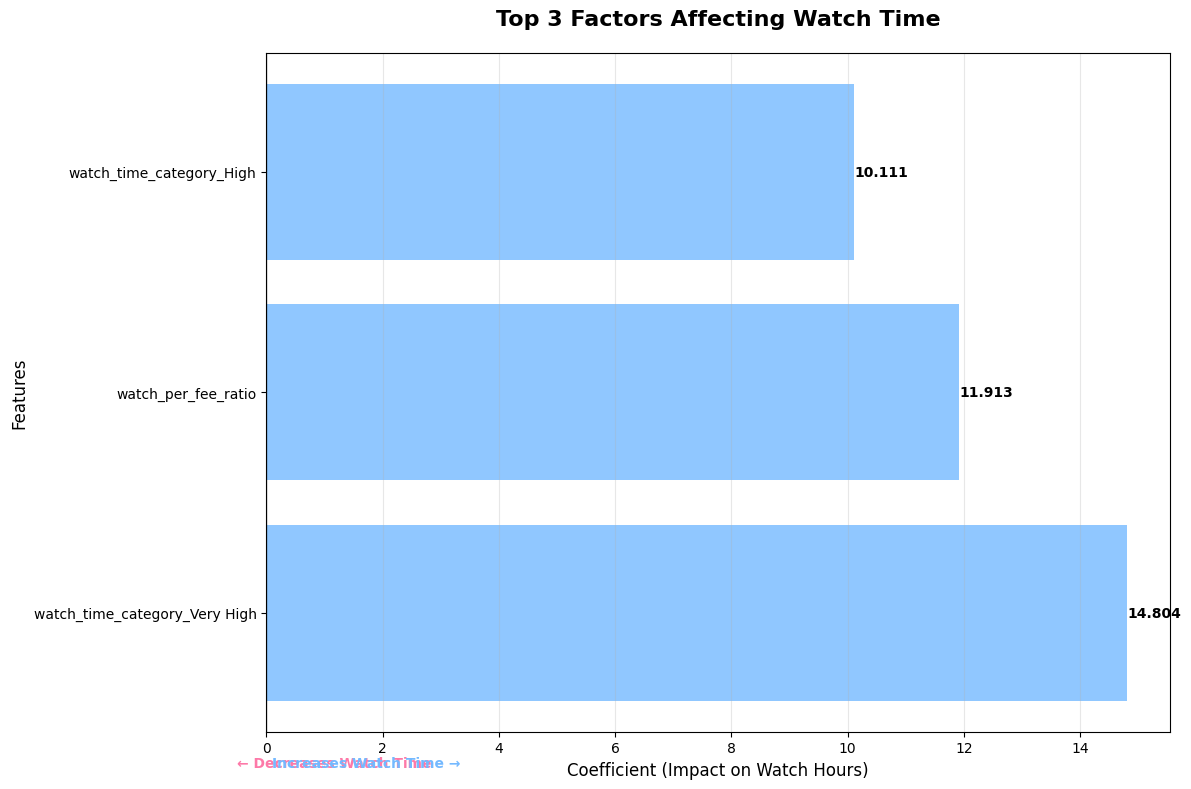

In [38]:
print(f"\n6️⃣ FACTORS AFFECTING WATCH TIME (LINEAR REGRESSION INSIGHTS):")
top_3_lin_features = lin_feature_importance.head(3)
print("Top 3 factors affecting watch hours:")
for i, (_, row) in enumerate(top_3_lin_features.iterrows(), 1):
    direction = "increases" if row['coefficient'] > 0 else "decreases"
    print(f"{i}. {row['feature']}: {direction} watch time (coef: {row['coefficient']:.3f})")

# VISUALIZATION 6: Factors Affecting Watch Time
plt.figure(figsize=(12, 8))
colors = ['#74B9FF' if coef > 0 else '#FD79A8' for coef in top_3_lin_features['coefficient']]
bars = plt.barh(top_3_lin_features['feature'], top_3_lin_features['coefficient'], color=colors, alpha=0.8)
plt.title('Top 3 Factors Affecting Watch Time', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Coefficient (Impact on Watch Hours)', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.axvline(x=0, color='black', linestyle='-', alpha=0.5, linewidth=1)

for bar, value in zip(bars, top_3_lin_features['coefficient']):
    plt.text(value + (0.01 if value > 0 else -0.01), bar.get_y() + bar.get_height()/2,
            f'{value:.3f}', ha='left' if value > 0 else 'right', va='center',
            fontweight='bold', fontsize=10)

# Add legend
plt.text(-0.5, -0.7, '← Decreases Watch Time', color='#FD79A8', fontweight='bold', fontsize=10)
plt.text(0.1, -0.7, 'Increases Watch Time →', color='#74B9FF', fontweight='bold', fontsize=10)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

## SEGMENT ANALYSIS (STRETCH GOAL)

🌍 CHURN BY COUNTRY:
         count   mean
country              
UK         240  0.271
France     254  0.240
India      258  0.240
Germany    246  0.228
USA        234  0.214
Canada     265  0.211

💳 CHURN BY SUBSCRIPTION TYPE:
                   count   mean
subscription_type              
Standard             493  0.247
Basic                505  0.238
Premium              499  0.216


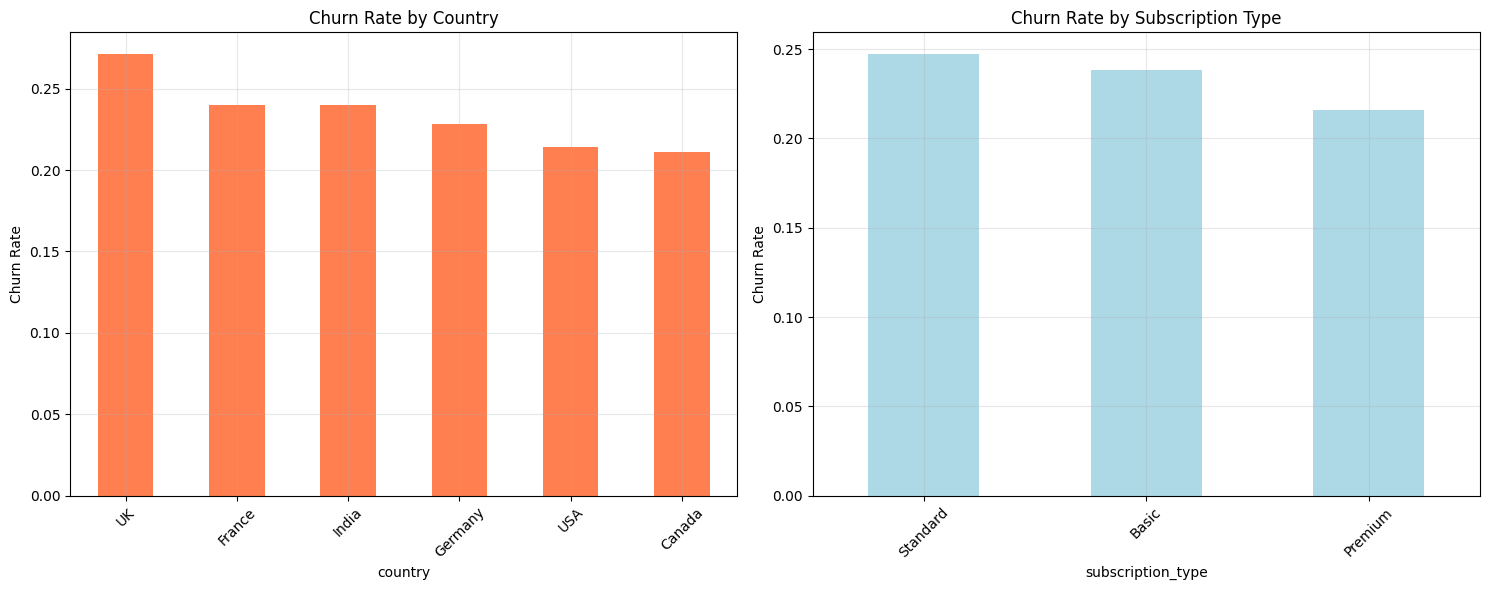

In [39]:
# Churn by country
print("🌍 CHURN BY COUNTRY:")
if 'country' in df_clean.columns:
    country_churn = df_clean.groupby('country')['is_churned'].agg(['count', 'mean']).round(3)
    country_churn = country_churn.sort_values('mean', ascending=False)
    print(country_churn)

# Churn by subscription type
print(f"\n💳 CHURN BY SUBSCRIPTION TYPE:")
if 'subscription_type' in df_clean.columns:
    subscription_churn = df_clean.groupby('subscription_type')['is_churned'].agg(['count', 'mean']).round(3)
    subscription_churn = subscription_churn.sort_values('mean', ascending=False)
    print(subscription_churn)

# Create visualization for segment analysis
if all(col in df_clean.columns for col in ['country', 'subscription_type']):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Country churn rates
    country_churn['mean'].plot(kind='bar', ax=ax1, color='coral')
    ax1.set_title('Churn Rate by Country')
    ax1.set_ylabel('Churn Rate')
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(True, alpha=0.3)

    # Subscription type churn rates
    subscription_churn['mean'].plot(kind='bar', ax=ax2, color='lightblue')
    ax2.set_title('Churn Rate by Subscription Type')
    ax2.set_ylabel('Churn Rate')
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

In [40]:
print("📊 KEY FINDINGS SUMMARY:")
print(f"• Overall churn rate: {df_clean['is_churned'].mean():.2%}")
print(f"• Best model performance: {max(roc_auc, roc_auc_best, roc_auc_rf):.3f} ROC-AUC")
print(f"• Most important churn predictors: {', '.join(feature_importance.head(3)['feature'].tolist())}")

📊 KEY FINDINGS SUMMARY:
• Overall churn rate: 23.38%
• Best model performance: 0.553 ROC-AUC
• Most important churn predictors: watch_time_category_Very High, average_watch_hours, age_group_65+


## CLASS IMBALANCE HANDLING (STRETCH GOAL)

In [41]:
# Check class distribution
print("📊 ORIGINAL CLASS DISTRIBUTION:")
original_distribution = Counter(y_train)
print(f"Class distribution: {dict(original_distribution)}")
print(f"Imbalance ratio: {original_distribution[0] / original_distribution[1]:.2f}:1 (Retained:Churned)")

📊 ORIGINAL CLASS DISTRIBUTION:
Class distribution: {1.0: 280, 0.0: 917}
Imbalance ratio: 3.27:1 (Retained:Churned)


In [42]:
# Method 1: SMOTE (Synthetic Minority Oversampling Technique)
print(f"\n🔄 METHOD 1: SMOTE OVERSAMPLING")
try:
    smote = SMOTE(random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

    smote_distribution = Counter(y_train_smote)
    print(f"✅ SMOTE applied successfully")
    print(f"New class distribution: {dict(smote_distribution)}")
    print(f"Training set size: {len(X_train_smote)} (was {len(X_train_scaled)})")

    # Train model with SMOTE data
    lr_smote = LogisticRegression(random_state=42, max_iter=1000)
    lr_smote.fit(X_train_smote, y_train_smote)

    # Evaluate SMOTE model
    y_pred_smote = lr_smote.predict(X_test_scaled)
    y_pred_proba_smote = lr_smote.predict_proba(X_test_scaled)[:, 1]

    accuracy_smote = accuracy_score(y_test, y_pred_smote)
    precision_smote = precision_score(y_test, y_pred_smote)
    recall_smote = recall_score(y_test, y_pred_smote)
    f1_smote = f1_score(y_test, y_pred_smote)
    roc_auc_smote = roc_auc_score(y_test, y_pred_proba_smote)

    print(f"SMOTE Model Performance:")
    print(f"  Accuracy:  {accuracy_smote:.4f}")
    print(f"  Precision: {precision_smote:.4f}")
    print(f"  Recall:    {recall_smote:.4f}")
    print(f"  F1-Score:  {f1_smote:.4f}")
    print(f"  ROC-AUC:   {roc_auc_smote:.4f}")

except ImportError:
    print("❌ SMOTE not available. Install imbalanced-learn: pip install imbalanced-learn")
    # Fallback values for comparison
    accuracy_smote = precision_smote = recall_smote = f1_smote = roc_auc_smote = 0


🔄 METHOD 1: SMOTE OVERSAMPLING
✅ SMOTE applied successfully
New class distribution: {1.0: 917, 0.0: 917}
Training set size: 1834 (was 1197)
SMOTE Model Performance:
  Accuracy:  0.5367
  Precision: 0.2518
  Recall:    0.5000
  F1-Score:  0.3349
  ROC-AUC:   0.5097


In [43]:
# Method 2: Random Undersampling
print(f"\n🔄 METHOD 2: RANDOM UNDERSAMPLING")
try:
    undersampler = RandomUnderSampler(random_state=42)
    X_train_under, y_train_under = undersampler.fit_resample(X_train_scaled, y_train)

    under_distribution = Counter(y_train_under)
    print(f"✅ Undersampling applied successfully")
    print(f"New class distribution: {dict(under_distribution)}")
    print(f"Training set size: {len(X_train_under)} (was {len(X_train_scaled)})")

    # Train model with undersampled data
    lr_under = LogisticRegression(random_state=42, max_iter=1000)
    lr_under.fit(X_train_under, y_train_under)

    # Evaluate undersampled model
    y_pred_under = lr_under.predict(X_test_scaled)
    y_pred_proba_under = lr_under.predict_proba(X_test_scaled)[:, 1]

    accuracy_under = accuracy_score(y_test, y_pred_under)
    precision_under = precision_score(y_test, y_pred_under)
    recall_under = recall_score(y_test, y_pred_under)
    f1_under = f1_score(y_test, y_pred_under)
    roc_auc_under = roc_auc_score(y_test, y_pred_proba_under)

    print(f"Undersampling Model Performance:")
    print(f"  Accuracy:  {accuracy_under:.4f}")
    print(f"  Precision: {precision_under:.4f}")
    print(f"  Recall:    {recall_under:.4f}")
    print(f"  F1-Score:  {f1_under:.4f}")
    print(f"  ROC-AUC:   {roc_auc_under:.4f}")

except ImportError:
    print("❌ RandomUnderSampler not available. Install imbalanced-learn: pip install imbalanced-learn")
    # Fallback values for comparison
    accuracy_under = precision_under = recall_under = f1_under = roc_auc_under = 0


🔄 METHOD 2: RANDOM UNDERSAMPLING
✅ Undersampling applied successfully
New class distribution: {0.0: 280, 1.0: 280}
Training set size: 560 (was 1197)
Undersampling Model Performance:
  Accuracy:  0.4533
  Precision: 0.2062
  Recall:    0.4714
  F1-Score:  0.2870
  ROC-AUC:   0.4486


In [44]:
# Method 3: Class Weighting
print(f"\n⚖️ METHOD 3: CLASS WEIGHTING")

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))
print(f"✅ Calculated class weights: {class_weight_dict}")

# Train model with class weights
lr_weighted = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
lr_weighted.fit(X_train_scaled, y_train)

# Evaluate weighted model
y_pred_weighted = lr_weighted.predict(X_test_scaled)
y_pred_proba_weighted = lr_weighted.predict_proba(X_test_scaled)[:, 1]

accuracy_weighted = accuracy_score(y_test, y_pred_weighted)
precision_weighted = precision_score(y_test, y_pred_weighted)
recall_weighted = recall_score(y_test, y_pred_weighted)
f1_weighted = f1_score(y_test, y_pred_weighted)
roc_auc_weighted = roc_auc_score(y_test, y_pred_proba_weighted)

print(f"Class Weighted Model Performance:")
print(f"  Accuracy:  {accuracy_weighted:.4f}")
print(f"  Precision: {precision_weighted:.4f}")
print(f"  Recall:    {recall_weighted:.4f}")
print(f"  F1-Score:  {f1_weighted:.4f}")
print(f"  ROC-AUC:   {roc_auc_weighted:.4f}")


⚖️ METHOD 3: CLASS WEIGHTING
✅ Calculated class weights: {np.float64(0.0): np.float64(0.6526717557251909), np.float64(1.0): np.float64(2.1375)}
Class Weighted Model Performance:
  Accuracy:  0.5100
  Precision: 0.2450
  Recall:    0.5286
  F1-Score:  0.3348
  ROC-AUC:   0.5148



📊 CLASS IMBALANCE METHODS COMPARISON:
            Method  Accuracy  Precision  Recall  F1-Score  ROC-AUC
0         Original    0.7667     0.0000  0.0000    0.0000   0.5166
1            SMOTE    0.5367     0.2518  0.5000    0.3349   0.5097
2    Undersampling    0.4533     0.2062  0.4714    0.2870   0.4486
3  Class Weighting    0.5100     0.2450  0.5286    0.3348   0.5148


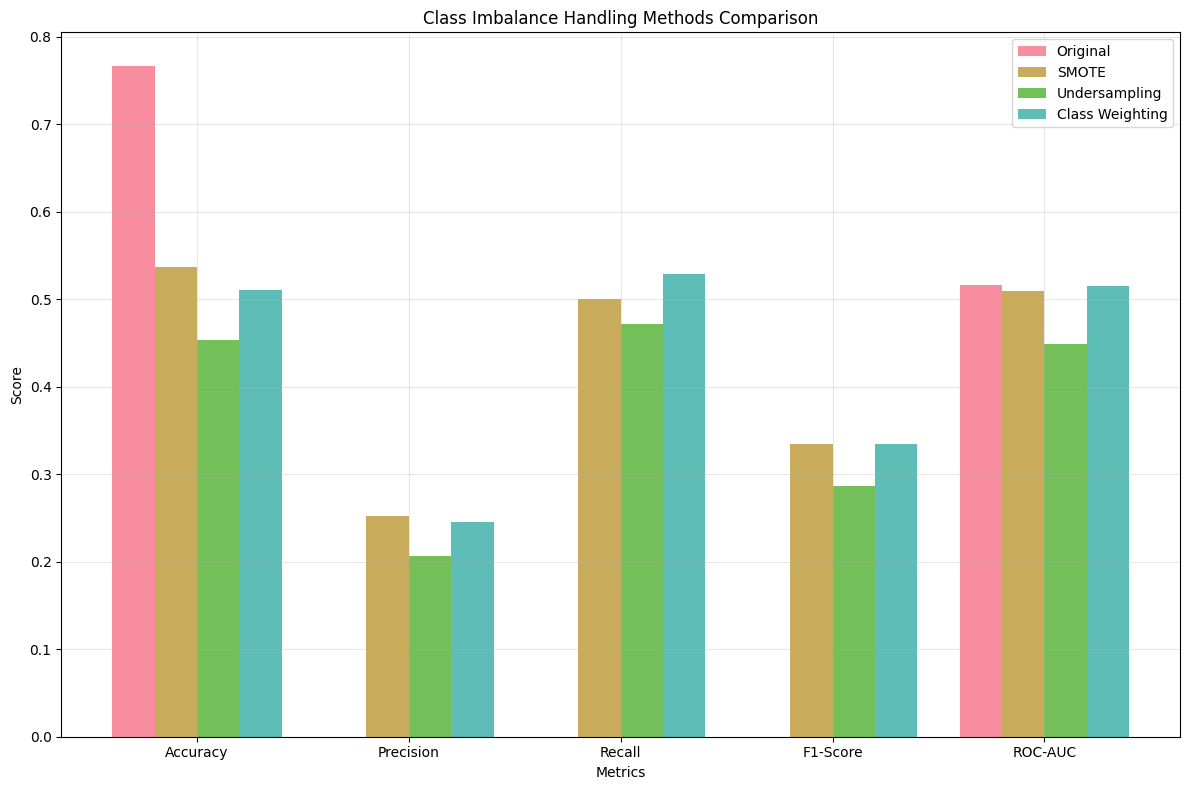

In [45]:
# Compare all imbalance handling methods
print(f"\n📊 CLASS IMBALANCE METHODS COMPARISON:")
imbalance_comparison = pd.DataFrame({
    'Method': ['Original', 'SMOTE', 'Undersampling', 'Class Weighting'],
    'Accuracy': [accuracy, accuracy_smote, accuracy_under, accuracy_weighted],
    'Precision': [precision, precision_smote, precision_under, precision_weighted],
    'Recall': [recall, recall_smote, recall_under, recall_weighted],
    'F1-Score': [f1, f1_smote, f1_under, f1_weighted],
    'ROC-AUC': [roc_auc, roc_auc_smote, roc_auc_under, roc_auc_weighted]
})

print(imbalance_comparison.round(4))

# Plot comparison
plt.figure(figsize=(12, 8))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
x = np.arange(len(metrics))
width = 0.2

plt.bar(x - 1.5*width, imbalance_comparison.iloc[0][1:].values, width, label='Original', alpha=0.8)
plt.bar(x - 0.5*width, imbalance_comparison.iloc[1][1:].values, width, label='SMOTE', alpha=0.8)
plt.bar(x + 0.5*width, imbalance_comparison.iloc[2][1:].values, width, label='Undersampling', alpha=0.8)
plt.bar(x + 1.5*width, imbalance_comparison.iloc[3][1:].values, width, label='Class Weighting', alpha=0.8)

plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Class Imbalance Handling Methods Comparison')
plt.xticks(x, metrics)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## TIME SERIES FORECASTING (STRETCH GOAL)

📈 EXPLORING TEMPORAL TRENDS IN CUSTOMER DATA

📅 SIGNUP TRENDS ANALYSIS:
✅ Analyzed 37 months of signup data
Signup trend summary:
              signups  churn_rate
signup_month                     
2024-10            46    0.217391
2024-11            43    0.232558
2024-12            41    0.219512
2025-01            45    0.200000
2025-02            31    0.193548
2025-03            43    0.232558
2025-04            40    0.175000
2025-05            58    0.224138
2025-06            41    0.195122
2025-07            19    0.210526


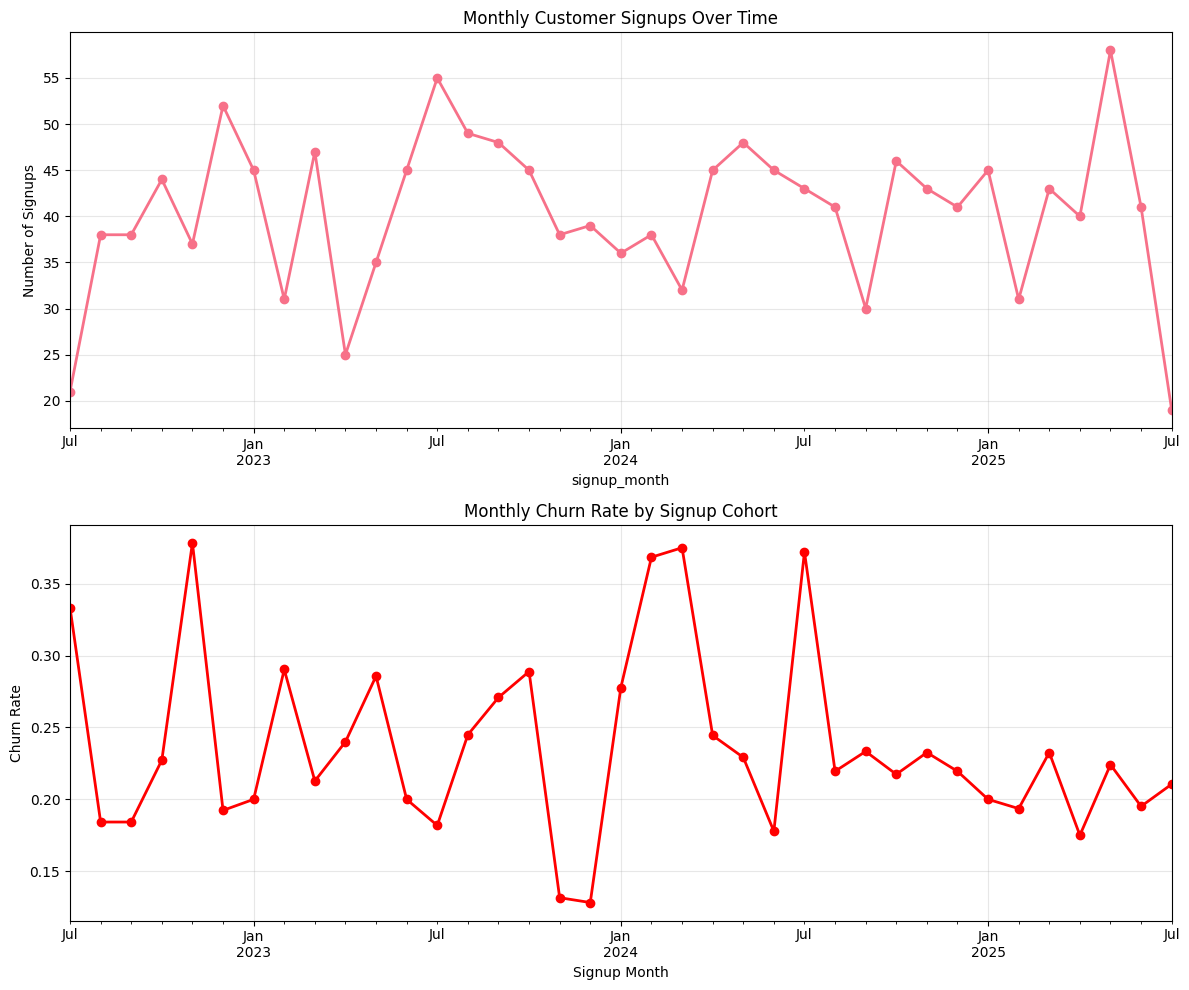

Average monthly signup growth rate: 3.9%

👥 COHORT ANALYSIS:
✅ Cohort analysis completed
Cohort retention rates (first 6 months):
period_number    0    1    2    3    4    5    6
signup_period                                   
2022-07        NaN  NaN  NaN  NaN  NaN  NaN  NaN
2022-08        NaN  NaN  NaN  NaN  NaN  NaN  NaN
2022-09        NaN  NaN  NaN  NaN  NaN  NaN  NaN
2022-10        NaN  NaN  NaN  NaN  NaN  NaN  NaN
2022-11        NaN  NaN  NaN  NaN  NaN  NaN  NaN
2022-12        NaN  NaN  NaN  NaN  NaN  NaN  NaN
2023-01        NaN  NaN  NaN  NaN  NaN  NaN  NaN
2023-02        NaN  NaN  NaN  NaN  NaN  NaN  NaN
2023-03        NaN  NaN  NaN  NaN  NaN  NaN  NaN
2023-04        NaN  NaN  NaN  NaN  NaN  NaN  NaN
2023-05        NaN  NaN  NaN  NaN  NaN  NaN  NaN
2023-06        NaN  NaN  NaN  NaN  NaN  NaN  NaN
2023-07        NaN  NaN  NaN  NaN  NaN  NaN  NaN
2023-08        NaN  NaN  NaN  NaN  NaN  NaN  NaN
2023-09        NaN  NaN  NaN  NaN  NaN  NaN  NaN
2023-10        NaN  NaN  NaN  NaN  Na

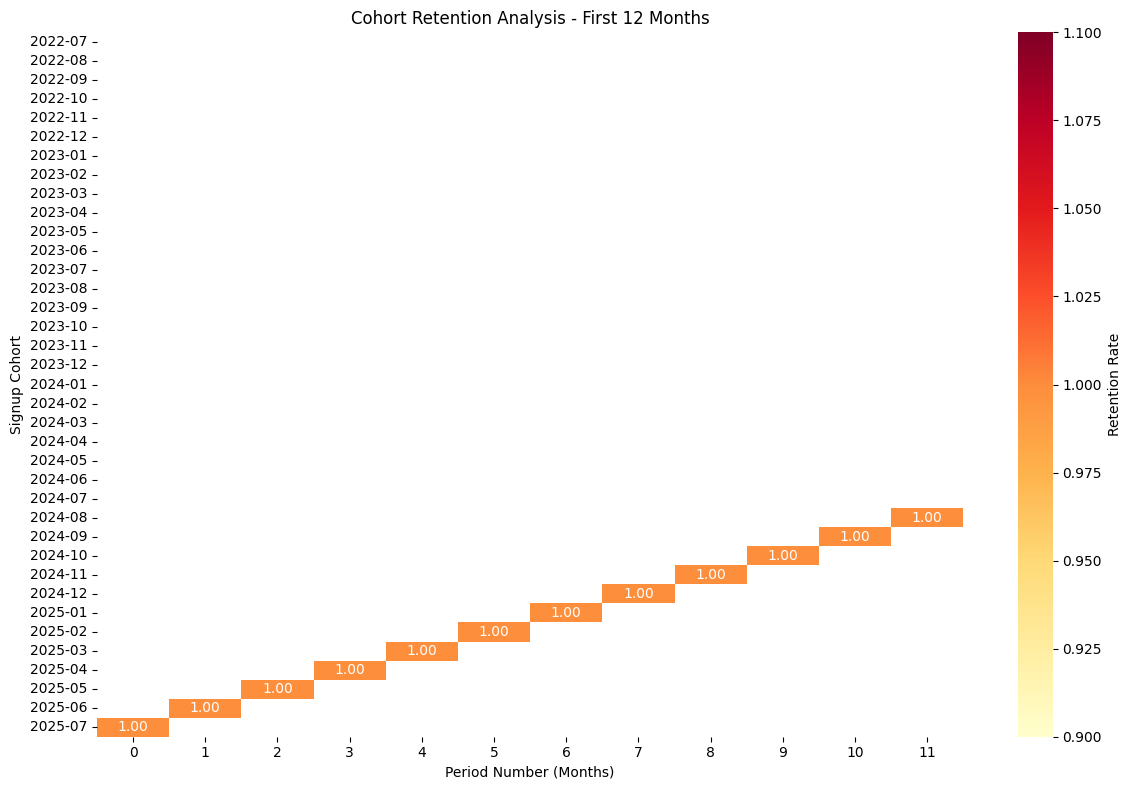


🌟 SEASONAL PATTERNS ANALYSIS:
✅ Seasonal churn analysis:

Month churn rates:
signup_month_num
1     0.222
2     0.290
3     0.262
4     0.218
5     0.241
6     0.191
7     0.268
8     0.219
9     0.233
10    0.244
11    0.246
12    0.182
Name: is_churned, dtype: float64

Quarter churn rates:
signup_quarter
1    0.256
2    0.217
3    0.241
4    0.223
Name: is_churned, dtype: float64

Day of Week churn rates:
signup_day_of_week
Friday       0.223
Monday       0.239
Saturday     0.224
Sunday       0.218
Thursday     0.243
Tuesday      0.250
Wednesday    0.236
Name: is_churned, dtype: float64


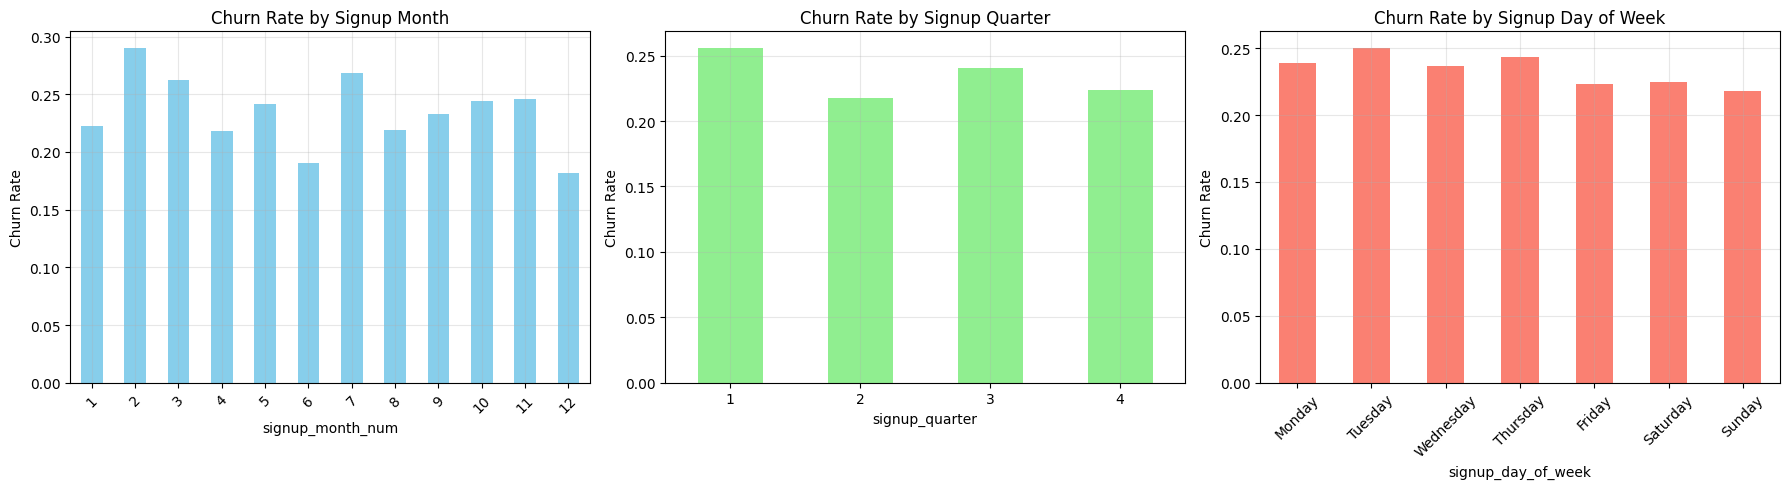


💰 CUSTOMER LIFETIME VALUE TRENDS:
✅ Customer Lifetime Value trends by signup cohort:
             estimated_clv               tenure_days monthly_fee
                      mean median    std        mean        mean
signup_month                                                    
2024-12              68.80  70.26  23.42      208.29        9.92
2025-01              59.92  59.94  21.71      177.62       10.10
2025-02              51.56  51.28  16.63      148.52       10.44
2025-03              38.88  38.30  14.06      119.09        9.83
2025-04              28.12  26.64   9.56       88.72        9.49
2025-05              18.68  18.31   6.78       58.19        9.65
2025-06               8.94   7.66   3.94       26.80       10.14
2025-07               2.35   2.20   1.42        7.32        9.62


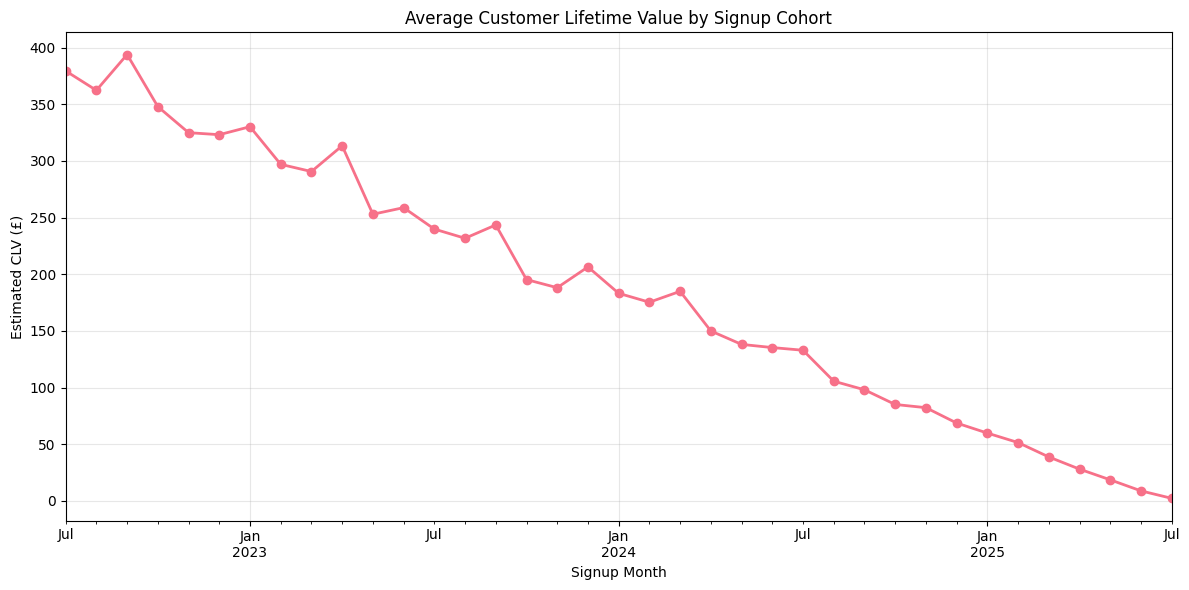


💡 CLV INSIGHTS:
Average CLV: £185.50
Churned customers CLV: £185.92
Retained customers CLV: £185.37
CLV difference: £-0.54 (-0.3% higher for retained)


In [46]:
print("📈 EXPLORING TEMPORAL TRENDS IN CUSTOMER DATA")

# 1. Signup trends over time
print(f"\n📅 SIGNUP TRENDS ANALYSIS:")
if 'signup_date' in df_clean.columns:
    # Create monthly signup aggregations
    df_clean['signup_month'] = df_clean['signup_date'].dt.to_period('M')
    signup_trends = df_clean.groupby('signup_month').agg({
        'user_id': 'count',
        'is_churned': 'mean'
    }).rename(columns={'user_id': 'signups', 'is_churned': 'churn_rate'})

    print(f"✅ Analyzed {len(signup_trends)} months of signup data")
    print(f"Signup trend summary:")
    print(signup_trends.tail(10))  # Show last 10 months

    # Plot signup trends
    fig, axes = plt.subplots(2, 1, figsize=(12, 10))

    # Monthly signups
    signup_trends.index = signup_trends.index.to_timestamp()
    signup_trends['signups'].plot(ax=axes[0], marker='o', linewidth=2)
    axes[0].set_title('Monthly Customer Signups Over Time')
    axes[0].set_ylabel('Number of Signups')
    axes[0].grid(True, alpha=0.3)

    # Monthly churn rate
    signup_trends['churn_rate'].plot(ax=axes[1], marker='o', linewidth=2, color='red')
    axes[1].set_title('Monthly Churn Rate by Signup Cohort')
    axes[1].set_ylabel('Churn Rate')
    axes[1].set_xlabel('Signup Month')
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Calculate signup growth rate
    signup_trends['signup_growth'] = signup_trends['signups'].pct_change() * 100
    avg_growth = signup_trends['signup_growth'].mean()
    print(f"Average monthly signup growth rate: {avg_growth:.1f}%")

# 2. Cohort Analysis
print(f"\n👥 COHORT ANALYSIS:")
if all(col in df_clean.columns for col in ['signup_date', 'last_active_date']):
    # Create cohort table
    def get_cohort_table(df):
        # Define cohort based on signup month
        df['signup_period'] = df['signup_date'].dt.to_period('M')
        df['last_active_period'] = df['last_active_date'].dt.to_period('M')

        # Calculate period number (months since signup)
        df['period_number'] = (df['last_active_period'] - df['signup_period']).apply(attrgetter('n'))

        # Create cohort table
        cohort_data = df.groupby(['signup_period', 'period_number'])['user_id'].nunique().reset_index()
        cohort_sizes = df.groupby('signup_period')['user_id'].nunique()

        cohort_table = cohort_data.pivot(index='signup_period',
                                       columns='period_number',
                                       values='user_id')

        # Calculate retention rates
        cohort_retention = cohort_table.divide(cohort_sizes, axis=0)

        return cohort_retention

    try:
        from operator import attrgetter
        cohort_retention = get_cohort_table(df_clean.copy())

        print(f"✅ Cohort analysis completed")
        print(f"Cohort retention rates (first 6 months):")
        print(cohort_retention.iloc[:, :7].round(3))  # Show first 6 months

        # Plot cohort heatmap
        plt.figure(figsize=(12, 8))
        sns.heatmap(cohort_retention.iloc[:, :12],  # First 12 months
                   annot=True, fmt='.2f', cmap='YlOrRd',
                   cbar_kws={'label': 'Retention Rate'})
        plt.title('Cohort Retention Analysis - First 12 Months')
        plt.ylabel('Signup Cohort')
        plt.xlabel('Period Number (Months)')
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"⚠️ Cohort analysis error: {e}")

# 3. Seasonal patterns
print(f"\n🌟 SEASONAL PATTERNS ANALYSIS:")
if 'signup_date' in df_clean.columns:
    # Extract seasonal components
    df_clean['signup_month_num'] = df_clean['signup_date'].dt.month
    df_clean['signup_quarter'] = df_clean['signup_date'].dt.quarter
    df_clean['signup_day_of_week'] = df_clean['signup_date'].dt.day_name()

    # Analyze seasonal churn patterns
    seasonal_analysis = {
        'Month': df_clean.groupby('signup_month_num')['is_churned'].mean(),
        'Quarter': df_clean.groupby('signup_quarter')['is_churned'].mean(),
        'Day of Week': df_clean.groupby('signup_day_of_week')['is_churned'].mean()
    }

    print("✅ Seasonal churn analysis:")
    for period, data in seasonal_analysis.items():
        print(f"\n{period} churn rates:")
        print(data.round(3))

    # Plot seasonal patterns
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Monthly pattern
    seasonal_analysis['Month'].plot(kind='bar', ax=axes[0], color='skyblue')
    axes[0].set_title('Churn Rate by Signup Month')
    axes[0].set_ylabel('Churn Rate')
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].grid(True, alpha=0.3)

    # Quarterly pattern
    seasonal_analysis['Quarter'].plot(kind='bar', ax=axes[1], color='lightgreen')
    axes[1].set_title('Churn Rate by Signup Quarter')
    axes[1].set_ylabel('Churn Rate')
    axes[1].tick_params(axis='x', rotation=0)
    axes[1].grid(True, alpha=0.3)

    # Day of week pattern
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    seasonal_analysis['Day of Week'].reindex(day_order).plot(kind='bar', ax=axes[2], color='salmon')
    axes[2].set_title('Churn Rate by Signup Day of Week')
    axes[2].set_ylabel('Churn Rate')
    axes[2].tick_params(axis='x', rotation=45)
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# 4. Customer Lifetime Value Trends
print(f"\n💰 CUSTOMER LIFETIME VALUE TRENDS:")
if all(col in df_clean.columns for col in ['tenure_days', 'monthly_fee']):
    # Estimate CLV based on tenure and monthly fee
    df_clean['estimated_clv'] = (df_clean['tenure_days'] / 30) * df_clean['monthly_fee']

    # Analyze CLV by signup cohort
    clv_by_cohort = df_clean.groupby('signup_month').agg({
        'estimated_clv': ['mean', 'median', 'std'],
        'tenure_days': 'mean',
        'monthly_fee': 'mean'
    }).round(2)

    print("✅ Customer Lifetime Value trends by signup cohort:")
    print(clv_by_cohort.tail(8))  # Show last 8 months

    # Plot CLV trends
    plt.figure(figsize=(12, 6))
    clv_by_cohort.index = clv_by_cohort.index.to_timestamp()
    clv_by_cohort[('estimated_clv', 'mean')].plot(marker='o', linewidth=2)
    plt.title('Average Customer Lifetime Value by Signup Cohort')
    plt.ylabel('Estimated CLV (£)')
    plt.xlabel('Signup Month')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # CLV insights
    avg_clv = df_clean['estimated_clv'].mean()
    churned_clv = df_clean[df_clean['is_churned'] == 1]['estimated_clv'].mean()
    retained_clv = df_clean[df_clean['is_churned'] == 0]['estimated_clv'].mean()

    print(f"\n💡 CLV INSIGHTS:")
    print(f"Average CLV: £{avg_clv:.2f}")
    print(f"Churned customers CLV: £{churned_clv:.2f}")
    print(f"Retained customers CLV: £{retained_clv:.2f}")
    print(f"CLV difference: £{retained_clv - churned_clv:.2f} ({((retained_clv - churned_clv)/churned_clv)*100:.1f}% higher for retained)")